* [Yelp, Not Kaggle Data Source](https://www.yelp.com/dataset/download)
* [Data Dictionary](https://www.yelp.com/dataset/documentation/main)

* [x] Get data into csv to work in pandas
* [x] Perform sentiment classification with Hugging Face model (2024 SOTA)
* [ ] Extract from text key words that resulted in sentiment class (entity-based sentiment analysis)
* [x] topic modeling
* [ ] other advanced analytics for reviews using LLM/HuggingFace
* [ ] compare competition side-by-side (Japanese restaurants)
* [ ] get criteria for ranking/qualities in restaurant based on aggregation of common words through clustering

In [1]:
!pip install duckdb jupysql -q transformers torch bertopic --quiet 
!python -m spacy download en_core_web_md --quiet

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
# Data Processing
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Processing and Model Inference
from nltk.corpus import stopwords
import torch
import nltk
from transformers import pipeline, AutoTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Vader

# Topic Modeling
import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim import corpora
from gensim.models.ldamodel import LdaModel

from bertopic import BERTopic

from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

# Generate different embeddings
import tensorflow
import tensorflow_hub as hub

Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-06-06 01:06:49.665013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 01:06:49.665197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 01:06:49.824477: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')
dfr.head()

/tmp/ipykernel_18/3121522079.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')


,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,review_id,user_id,review_stars,text,date
0,0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area.",2014-05-26 01:09:53
1,1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town.",2013-10-05 15:19:06
2,2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite.",2013-10-25 01:34:57
3,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,I ordered a graduation cake for my niece and 

In [4]:
dfr['categories'].value_counts()[:20]                                                                           

categories
Mexican, Restaurants                                      44958
Restaurants, Mexican                                      44000
Restaurants, Pizza                                        26614
Pizza, Restaurants                                        23189
Restaurants, Chinese                                      20683
Restaurants, Italian                                      20287
Chinese, Restaurants                                      19357
Italian, Restaurants                                      18799
Thai, Restaurants                                         13613
Seafood, Restaurants                                      11885
American (New), Restaurants                               11169
Restaurants, American (New)                               11037
Restaurants, Thai                                         10190
Cajun/Creole, Seafood, Restaurants                         9115
Restaurants, Seafood                                       8886
Vietnamese, Restaurants      

In [5]:
# Need to clean up category data

query = """
select business_id
, name
, address
, city
, state
, postal_code
, latitude
, longitude
, stars
, review_count
, attributes
, case when categories = 'Mexican, Restaurants' then 'Restaurants, Mexican'
when categories = 'Pizza, Restaurants' then 'Restaurants, Pizza'
when categories = 'Chinese, Restaurants' then 'Restaurants, Chinese'
when categories = 'Italian, Restaurants' then 'Restaurants, Italian'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'American (New), Restaurants' then 'Restaurants, American (New)'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'Vietnamese, Restaurants' then 'Restaurants, Vietnamese'
when categories = 'Cajun/Creole, Restaurants' then 'Restaurants, Cajun/Creole'
else categories
end as categories
, review_id
, user_id
, review_stars
, text
, date
from dfr
"""

dfr = duckdb.query(query).df()
dfr['categories'].value_counts()[:20]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

categories
Restaurants, Mexican                                                                                     88958
Restaurants, Pizza                                                                                       49803
Restaurants, Chinese                                                                                     40040
Restaurants, Italian                                                                                     39086
Restaurants, Thai                                                                                        23803
Restaurants, American (New)                                                                              22206
Restaurants, Seafood                                                                                     20771
Restaurants, Vietnamese                                                                                  15508
Restaurants, Cajun/Creole                                                                            

In [6]:
dfr['categories'].value_counts()[:20]

categories
Restaurants, Mexican                                                                                     88958
Restaurants, Pizza                                                                                       49803
Restaurants, Chinese                                                                                     40040
Restaurants, Italian                                                                                     39086
Restaurants, Thai                                                                                        23803
Restaurants, American (New)                                                                              22206
Restaurants, Seafood                                                                                     20771
Restaurants, Vietnamese                                                                                  15508
Restaurants, Cajun/Creole                                                                            

In [7]:
query = """
select review_id
, review_stars
, text
from dfr
"""

df_sent2 = duckdb.query(query).df()
df_sent2

,review_id,review_stars,text
0,BXQcBN0iAi1lAUxibGLFzA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area."
1,uduvUCvi9w3T2bSGivCfXg,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town."
2,a0vwPOqDXXZuJkbBW2356g,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite."
3,MKNp_CdR2k2202-c8GN5Dw,5.0,I ordered a graduation cake for my niece and it came out absolutely perfect. Will come again for future events! Staff was nice also and the cake was really good.
4,D1GisLDPe84Rrk_R4X2brQ,4.0,"HK-STYLE MILK TEA: FOUR STARS\n\nNot quite sure why there are two Saint Honore Pastries business listings on Yelp, but I have been checking in to this one.\n\nBoyfriend and I go by it all the time while in Chinatown, but it never crossed our mind to try it. I think we might have tried it once a year or two ago, but it wasn't memorable. I decided to try the HK-style milk tea not too long ago and was hooked. I think I went here almost every day one week to get the milk tea, only to realize that I should REALLY watch my sugar intake...it's sooo good! \n\nI personally don't think it's better than Zhong Gang's HK-style milk tea because they have their off days when a certain lady makes them (not enough ice, too much ice, etc.).\n\nOn a side note: I wanted to try the crispy roast pork bun, but accidentally said the wrong name in Chinese and got the roast pork bun. It was decent enough, although I will get to trying the crispy roast pork bun soon! \n\nI will be back~"
...,...,...,...
3773767,Kt3gFeW1rhZz7RuiV-6Tcw,5.0,"This is my favorite food truck! I only wish I lived closer to Philly so that I could eat here more often. The prices are affordable, the portions are generous, the staff is friendly, and the food is AMAZING. \n\nThe last time I went to the Plum Pit, I ordered a jerk chicken sandwich to split with a friend. Learn from our mistake--order your own sandwich, and if you can't finish it, save half for later. We ended up going back for another sandwich (the one with chicken tenders, mac & cheese, and bacon--I can't remember the name) anyway. We also got two orders of bread pudding to bring home, which, though pretty good cold, is ever better when you heat it up in the oven for 10-15 minutes."
3773768,ruy3Ycey_gGbwkE_3TX1Fg,5.0,"This food truck was stupid. Stupidly delicious. \n\nShould be a 4.5 because they were a little slow compared to other trucks, but once the food showed up, totally ON POINT.\n\nWe had the bacon Mac and cheese with the French fry bowl, topped with jerk chicken. I could not get enough of the jerk chicken. And the bacon Mac and cheese was super creamy ( again 4.5 we saw a big can of nacho cheese instead of good cheese "" . \n\nWould definitely eat here again if they were at the Stables."
3773769,C_l8NTpvNOEUorEmEOusaA,5.0,Bubba never disappoints i go to his fb page and hunt him down and now i have my friends and family stalking him too. One of the main r

In [8]:
# reduce file size by getting sample
#sample 500,000 to use less RAM
sample = df_sent2.sample(n=500000)
len(sample)

500000

In [9]:
sample.head(1)

,review_id,review_stars,text
348691,MeU7Q9M8NNO9ZKX4t3U3rg,3.0,"I'd been to the original Turnip Truck near Five Corners and wasn't impressed. I never found any reason to go back due to the high prices, very limited space, and difficulty to reach from anywhere outside of East Nashville.\n\nAnd for an embarrassing reason, I ran into the Turnip Truck for a desperation beverage (spicy mouth), and for the moment I was there, it looked great. Open, clean, modern: it was everything the East End version wasn't, except for the high prices. The beverage selection was great, and I saw they had a barista bar, which intrigued me. So when I recently had a free moment, I went back to give their coffees a shot.\n\nThe verdict: outstanding but very expensive for a single latte. I enjoyed the drink thoroughly, but was dismayed at the price. The drink itself will haunt me whenever I go to the gulch, not because it was the best in town (but it was up there), but that even though it was really good, I just don't have the means to pay that much for such a small drink.\n\nIf you're in the store, and you need a burst of energy, it will more than satisfy (and you're probably the type that can afford to shop there, anyway), but if you're tooling around between downtown and West End, get to Casablanca, it's just that much better."


# Text Pre-Processing

In [10]:
# text column needs to be changed to string...
sample['text'] = sample['text'].apply(str)

In [11]:
# Get code to clean text of HTML tags, punctuation
def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', '')
    
sample['clean_text'] = sample.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
sample

,review_id,review_stars,text,clean_text
348691,MeU7Q9M8NNO9ZKX4t3U3rg,3.0,"I'd been to the original Turnip Truck near Five Corners and wasn't impressed. I never found any reason to go back due to the high prices, very limited space, and difficulty to reach from anywhere outside of East Nashville.\n\nAnd for an embarrassing reason, I ran into the Turnip Truck for a desperation beverage (spicy mouth), and for the moment I was there, it looked great. Open, clean, modern: it was everything the East End version wasn't, except for the high prices. The beverage selection was great, and I saw they had a barista bar, which intrigued me. So when I recently had a free moment, I went back to give their coffees a shot.\n\nThe verdict: outstanding but very expensive for a single latte. I enjoyed the drink thoroughly, but was dismayed at the price. The drink itself will haunt me whenever I go to the gulch, not because it was the best in town (but it was up there), but that even though it was really good, I just don't have the means to pay that much for such a small drink.\n\nIf you're in the store, and you need a burst of energy, it will more than satisfy (and you're probably the type that can afford to shop there, anyway), but if you're tooling around between downtown and West End, get to Casablanca, it's just that much better.","I'd been to the original Turnip Truck near Five Corners and wasn't impressed. I never found any reason to go back due to the high prices, very limited space, and difficulty to reach from anywhere outside of East Nashville. And for an embarrassing reason, I ran into the Turnip Truck for a desperation beverage (spicy mouth), and for the moment I was there, it looked great. Open, clean, modern: it was everything the East End version wasn't, except for the high prices. The beverage selection was great, and I saw they had a barista bar, which intrigued me. So when I recently had a free moment, I went back to give their coffees a shot. The verdict: outstanding but very expensive for a single latte. I enjoyed the drink thoroughly, but was dismayed at the price. The drink itself will haunt me whenever I go to the gulch, not because it was the best in town (but it was up there), but that even though it was really good, I just don't have the means to pay that much for such a small drink. If you're in the store, and you need a burst of energy, it will more than satisfy (and you're probably the type that can afford to shop there, anyway), but if you're tooling around between downtown and West End, get to Casablanca, it's just that much better."
1112880,hhws0-GPkPRCFOGtrLxmZw,5.0,I placed a large To-Go order and everything was on point! Food was extremely tasty and the order was ready super fast! And Meresa is the best! She made sure I had everything I needed for every single plate I ordered!,I placed a large To-Go order and everything was on point! Food was extremely tasty and the order was ready super fast! And Meresa is the best! She made sure I had everything I needed for every single plate I ordered!
2075326,0YzlyYaGfsXA43OyacjYvQ,5.0,"The location was nice and the top deck provides a beautiful view of the water. Dinner was tasty but I'm giving Crabby's 5 stars because of our server, Caleb. Caleb spent time with us, giving detailed advice about the food, making recommendations and telling us about the area. His attentiveness and friendly demeanor made the dining experience exceptional.","The location was nice and the top deck provides a beautiful view of the water. Dinner was tasty but I'm giving Crabby's 5 stars because of our server, Caleb. Caleb spent time with us, giving detailed advice about the food, making recommendations and telling us about the area. His attentiveness and friendly demeanor made the dining experience exceptional."
628757,4VQWdtigy1FQViO4ZDr_lA,2.0,"I keep trying, but I'm still not a fan. Food is very greasy. I'm gonna keep looking for an alternative to a Chinese restaurant in this neighborhood.","I

In [12]:
# normalize text by lowering it all
sample['clean_text'] = sample['clean_text'].str.lower()

In [13]:
%%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 500 total words as max length since tokenizer can add suffixes as a token
#2. eliminate tokens lengths greater than max/summarize text using chatgpt?

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# sentence = "Sentence to check whether it exceeds 512 tokens"

# tokenized_sentence = tokenizer.tokenize(sentence)

# print(len(sentence.split()))  # here is the default length of the sentence
# print(len(tokenized_sentence)) # here is the tokenized length

## Example applied to df

sample['num_tokens_tok'] = sample.apply(lambda row: len(tokenizer.tokenize(row.clean_text)), axis = 1)
sample.head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 5min 34s, sys: 68.8 ms, total: 5min 35s
Wall time: 5min 37s


,review_id,review_stars,text,clean_text,num_tokens_tok
348691,MeU7Q9M8NNO9ZKX4t3U3rg,3.0,"I'd been to the original Turnip Truck near Five Corners and wasn't impressed. I never found any reason to go back due to the high prices, very limited space, and difficulty to reach from anywhere outside of East Nashville.\n\nAnd for an embarrassing reason, I ran into the Turnip Truck for a desperation beverage (spicy mouth), and for the moment I was there, it looked great. Open, clean, modern: it was everything the East End version wasn't, except for the high prices. The beverage selection was great, and I saw they had a barista bar, which intrigued me. So when I recently had a free moment, I went back to give their coffees a shot.\n\nThe verdict: outstanding but very expensive for a single latte. I enjoyed the drink thoroughly, but was dismayed at the price. The drink itself will haunt me whenever I go to the gulch, not because it was the best in town (but it was up there), but that even though it was really good, I just don't have the means to pay that much for such a small drink.\n\nIf you're in the store, and you need a burst of energy, it will more than satisfy (and you're probably the type that can afford to shop there, anyway), but if you're tooling around between downtown and West End, get to Casablanca, it's just that much better.","i'd been to the original turnip truck near five corners and wasn't impressed. i never found any reason to go back due to the high prices, very limited space, and difficulty to reach from anywhere outside of east nashville. and for an embarrassing reason, i ran into the turnip truck for a desperation beverage (spicy mouth), and for the moment i was there, it looked great. open, clean, modern: it was everything the east end version wasn't, except for the high prices. the beverage selection was great, and i saw they had a barista bar, which intrigued me. so when i recently had a free moment, i went back to give their coffees a shot. the verdict: outstanding but very expensive for a single latte. i enjoyed the drink thoroughly, but was dismayed at the price. the drink itself will haunt me whenever i go to the gulch, not because it was the best in town (but it was up there), but that even though it was really good, i just don't have the means to pay that much for such a small drink. if you're in the store, and you need a burst of energy, it will more than satisfy (and you're probably the type that can afford to shop there, anyway), but if you're tooling around between downtown and west end, get to casablanca, it's just that much better.",294
1112880,hhws0-GPkPRCFOGtrLxmZw,5.0,I placed a large To-Go order and everything was on point! Food was extremely tasty and the order was ready super fast! And Meresa is the best! She made sure I had everything I needed for every single plate I ordered!,i placed a large to-go order and everything was on point! food was extremely tasty and the order was ready super fast! and meresa is the best! she made sure i had everything i needed for every single plate i ordered!,49
2075326,0YzlyYaGfsXA43OyacjYvQ,5.0,"The location was nice and the top deck provides a beautiful view of the water. Dinner was tasty but I'm giving Crabby's 5 stars because of our server, Caleb. Caleb spent time with us, giving detailed advice about the food, making recommendations and telling us about the area. His attentiveness and friendly demeanor made the dining experience exceptional.","the location was nice and the top deck provides a beautiful view of the water. dinner was tasty but i'm giving crabby's 5 stars because of our server, caleb. caleb spent time with us, giving detailed advice about the food, making recommendations and telling us about the area. his attentiveness and friendly demeanor made the dining experience exceptional.",74
628757,4VQWdtigy1FQViO4ZDr_lA,2.0,"I keep trying, but I'm still not a fan. Food is very greasy. I'm gonna keep looking for an alternative to a Chinese restaurant 

In [14]:
# get rid of rows that are <450 words in length since this tokenizer is approx of tokenizer used for sentiment model
query = """
select *
from sample
where num_tokens_tok < 450
"""

sample_short_rev = duckdb.query(query).df()
sample_short_rev.head()

,review_id,review_stars,text,clean_text,num_tokens_tok
0,MeU7Q9M8NNO9ZKX4t3U3rg,3.0,"I'd been to the original Turnip Truck near Five Corners and wasn't impressed. I never found any reason to go back due to the high prices, very limited space, and difficulty to reach from anywhere outside of East Nashville.\n\nAnd for an embarrassing reason, I ran into the Turnip Truck for a desperation beverage (spicy mouth), and for the moment I was there, it looked great. Open, clean, modern: it was everything the East End version wasn't, except for the high prices. The beverage selection was great, and I saw they had a barista bar, which intrigued me. So when I recently had a free moment, I went back to give their coffees a shot.\n\nThe verdict: outstanding but very expensive for a single latte. I enjoyed the drink thoroughly, but was dismayed at the price. The drink itself will haunt me whenever I go to the gulch, not because it was the best in town (but it was up there), but that even though it was really good, I just don't have the means to pay that much for such a small drink.\n\nIf you're in the store, and you need a burst of energy, it will more than satisfy (and you're probably the type that can afford to shop there, anyway), but if you're tooling around between downtown and West End, get to Casablanca, it's just that much better.","i'd been to the original turnip truck near five corners and wasn't impressed. i never found any reason to go back due to the high prices, very limited space, and difficulty to reach from anywhere outside of east nashville. and for an embarrassing reason, i ran into the turnip truck for a desperation beverage (spicy mouth), and for the moment i was there, it looked great. open, clean, modern: it was everything the east end version wasn't, except for the high prices. the beverage selection was great, and i saw they had a barista bar, which intrigued me. so when i recently had a free moment, i went back to give their coffees a shot. the verdict: outstanding but very expensive for a single latte. i enjoyed the drink thoroughly, but was dismayed at the price. the drink itself will haunt me whenever i go to the gulch, not because it was the best in town (but it was up there), but that even though it was really good, i just don't have the means to pay that much for such a small drink. if you're in the store, and you need a burst of energy, it will more than satisfy (and you're probably the type that can afford to shop there, anyway), but if you're tooling around between downtown and west end, get to casablanca, it's just that much better.",294
1,hhws0-GPkPRCFOGtrLxmZw,5.0,I placed a large To-Go order and everything was on point! Food was extremely tasty and the order was ready super fast! And Meresa is the best! She made sure I had everything I needed for every single plate I ordered!,i placed a large to-go order and everything was on point! food was extremely tasty and the order was ready super fast! and meresa is the best! she made sure i had everything i needed for every single plate i ordered!,49
2,0YzlyYaGfsXA43OyacjYvQ,5.0,"The location was nice and the top deck provides a beautiful view of the water. Dinner was tasty but I'm giving Crabby's 5 stars because of our server, Caleb. Caleb spent time with us, giving detailed advice about the food, making recommendations and telling us about the area. His attentiveness and friendly demeanor made the dining experience exceptional.","the location was nice and the top deck provides a beautiful view of the water. dinner was tasty but i'm giving crabby's 5 stars because of our server, caleb. caleb spent time with us, giving detailed advice about the food, making recommendations and telling us about the area. his attentiveness and friendly demeanor made the dining experience exceptional.",74
3,4VQWdtigy1FQViO4ZDr_lA,2.0,"I keep trying, but I'm still not a fan. Food is very greasy. I'm gonna keep looking for an alternative to a Chinese restaurant in this neighborhood."

In [15]:
#Check max number tokens
query = """
select max(num_tokens_tok) as max_tokens
from sample_short_rev
"""

duckdb.query(query).df()

,max_tokens
0,449


In [16]:
# remaining of sample after token length filter
len(sample_short_rev)

488936

# Sentiment Classification

In [17]:
# using Hugging Face sentiment classifier trained on Yelp restaurant reviews

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="mrcaelumn/yelp_restaurant_review_sentiment_analysis")

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [18]:
test = sample_short_rev.sample(n=5000)

In [19]:
%%time

test = (
test.assign(sentiment = lambda x: x['clean_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

test.head()

CPU times: user 20min 41s, sys: 2.36 s, total: 20min 43s
Wall time: 10min 22s


,review_id,review_stars,text,clean_text,num_tokens_tok,sentiment,label,score
27503,O0UJZsl9gU5PnFCi7gZKNA,5.0,"Many years ago, I lived in Peru. I now live in Jacksonville, where we have only two Peruvian restaurants. Cazador Grill is one of many Peruvian restaurants in Tampa. It is excellent. My husband and I shared ceviche, anticuchos, and sudado de pescado. All were beyond excellent; all were authentic. I highly recommend this restaurant to aficiandos of Peruvian cuisine or to anyone who wants to experience good food.","many years ago, i lived in peru. i now live in jacksonville, where we have only two peruvian restaurants. cazador grill is one of many peruvian restaurants in tampa. it is excellent. my husband and i shared ceviche, anticuchos, and sudado de pescado. all were beyond excellent; all were authentic. i highly recommend this restaurant to aficiandos of peruvian cuisine or to anyone who wants to experience good food.",93,"[{'label': 'LABEL_2', 'score': 0.9974772334098816}]",LABEL_2,0.997477
19244,BYlQdqumrxNiNA4vS5ihdA,5.0,"I had the pleasure of visiting this restaurant last weekend with some friends who had been here before and highly recommended it. There was a great ambience about it...very cozy and dimly light, which is the type of atmosphere I search for when looking for restaurants to try. The staff were very friendly and were quick to give helpful opinions in ordering drinks and such. I first tried the sangria which was delicious. The bartender said it was their own special recipe with a secret ingredient. I definitely could taste something that made it different from other sangria I have tried, but couldn't quite put my finger on it. I also later ordered the house margarita....absolutely delicious and very fresh tasting. It is apparent that it is completely home made with fresh ingredients. We ordered the grilled calamari, garlic soup, rib eye, patatas, chorizo w/ manchego, brussel sprouts with pancetta and havarti cheese, fries, and lamb chops (TO DIE FOR).....don't cheat yourself....order extra lamb chops!) Everything was absolutely delicious. We ended our meal with espresso at the recommendation of our friends and it did not disappoint. The owner/chef (yes, the owner was in the kitchen cooking all of our food....you cant get any better than that) came out to greet us as we were finishing up which was very nice. He actually sat at the empty table next to us and we all talked about how he got started, how he built this establishment himself including the decor, plumbing and electric. His passion for cooking and his love/pride for his restaurant was very evident. We enjoyed the whole experience very much and will definitely visit again!","i had the pleasure of visiting this restaurant last weekend with some friends who had been here before and highly recommended it. there was a great ambience about it...very cozy and dimly light, which is the type of atmosphere i search for when looking for restaurants to try. the staff were very friendly and were quick to give helpful opinions in ordering drinks and such. i first tried the sangria which was delicious. the bartender said it was their own special recipe with a secret ingredient. i definitely could taste something that made it different from other sangria i have tried, but couldn't quite put my finger on it. i also later ordered the house margarita....absolutely delicious and very fresh tasting. it is apparent that it is completely home made with fresh ingredients. we ordered the grilled calamari, garlic soup, rib eye, patatas, chorizo w/ manchego, brussel sprouts with pancetta and havarti cheese, fries, and lamb chops (to die for).....don't cheat yourself....order extra lamb chops!) everything was absolutely delicious. we ended our meal with espresso at the recommendation of our friends and it did not disappoint. the owner/chef (yes, the owner was in the kitchen cooking all of our food....you cant get any better than that) came out to greet us as we were fin

In [20]:
# Sentiment Label Breakdown
test['label'].value_counts() # Mostly positive reviews

label
LABEL_2    3512
LABEL_0     960
LABEL_1     528
Name: count, dtype: int64

In [21]:
# LABEL_0 only

query = """
select clean_text
, review_stars
, label
, score
from test
where label = 'LABEL_0'
"""

label_0 = duckdb.query(query).df()
label_0.head()

,clean_text,review_stars,label,score
0,"our waitress acted like she didn't care if we got condiments for burgers, which shud have been on plate to start with..said she had to take other orders before bringing mustard to me...i was done eating by the time she materialized again.",1.0,LABEL_0,0.962302
1,"i had my worst meal ever. food must have sat under the heat lamp for a long time, everything was dried up.",1.0,LABEL_0,0.988161
2,"90% of the original menu so i wouldn't say limited. food was good as always. i had the 11oz filet. i always get it medium but the waiter this time mentioned getting it well and to have them butterfly it...""the worst"" i could have done. the bar is open and the inside seating tables are socially distanced. they also have outside seating as well.",3.0,LABEL_0,0.613213
3,"avoid at all costs... lived in the area for 10 years and this is the closest taco bell, the next closest one is 30 minutes away. it's gotten so bad i cannot go here anymore.. they mess up your order every single time! and don't even try to get them to fix it because all the workers are stunned and can't even speak english.. don't get me wrong i know it's fast food but when your workers are that bad and that stupid so constantly?? i i have never experienced such a bad establishment that for years have been so just god awful, i don't know how this place is even open....it's gotten to the point where i feel i'm getting ripped off and getting my money stolen from me after all the times i've had to throw my order away or where i'd rather not even eat my food then have to go deal with them inside. i don't even blame the workers i blame the owner of this franchise! what a crook, i will gladly drive 30 minutes to st. albert to get taco bell",1.0,LABEL_0,0.983037
4,"i am not sure if the staff first goes over to the slot machines in the airport to lose their money before their shift to hate life so much, maybe it is just their nature or they are just poorly managed. i only had a beer at the bar but it was directly next to the kitchen. the amount of complaining that comes out of this wait staff is amazing. he was not my server but based on the nose in the sky and filthy language used - if you see ricky come up to your table you should quit there and stop by mcdonald's next door. they all smile when the are next to me talking to each other but mostly because they appear to bound together to hate on everything and everyone in this restaurant. i am so happy i do not need to go through this airport often and even happier i was not hungry when i sat down. the food that is passed behind me looks like you would eat it only if you had no other choice. i would give another star for their beer selection (nice local taps) but it got knocked back down to one to make a point to avoid this place at any cost.",1.0,LABEL_0,0.497698


In [22]:
label_0['review_stars'].value_counts() #for lowest star ratings/negative sentiment

review_stars
1.0    548
2.0    283
3.0    109
4.0     12
5.0      8
Name: count, dtype: int64

In [23]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
query = """
select clean_text
, review_stars
, label
, score
from label_0
where review_stars >=4
"""

bad_labels_0 = duckdb.query(query).df()
bad_labels_0

,clean_text,review_stars,label,score
0,food so you good you won't want to leave. literally just waited 90 minutes for a table of 4 on a thursday night.,4.0,LABEL_0,0.918780
1,"look, i had a craving for soft serve, so instead of killing my regimen, i voted for slenderina-custard. in a cone. well the girl behind the counter, added sprinkles, could she be more sparse with it. ??!!?? wtf??!! additional .45 more, & i could count how many she put on there, on the whole cone.wow? was gonna something, but i'll just make comment when go back, maybe get some one else.damn, i know everyone's on budget, economy hitting hard, but s***!!..",4.0,LABEL_0,0.511454
2,when you go to sign up for their online ordering there's no coupon code to enter in there and the store will not honor it if you order in. update : they honored the 10% discount in the store when notified of the online coupon code issue.,5.0,LABEL_0,0.754809
3,"our server bradley was the fucking boss. he's known as ""fast food connoisseur."" he's divorced and doesn't get along with his current girlfriend because she doesn't attend to his ""needs."" in all honesty request this guy. this post may seem as a joke but he's a real man whom doesn't mess around with his job. he keeps the shift running like the guards at aushwitz. keep your head up bradley!",5.0,LABEL_0,0.952167
4,"five stars because the food is always top notch. but we were disappointed in the service at lunch today. our server was quick to bring waters and take our drink order, the drinks came out quickly and she took our food order. the wait for our food was too long, approx 25 minutes on a slow day. only 5 tables occupied. this may have been due to the kitchen. she served our food and disappeared. we ate, we drank, our drinks ran dry so then we just ate. after leaving us untended for almost 40 minutes she came back. she took a desert order but did not offer refills. again the interval seemed too long ( maybe the kitchen). when desert arrived it was accompanied by the check. we offered the credit card. it came back quickly, along with, can you imagine, a refill of our water glasses. this was a disappointing visit and more so as pi is always much better than that.",5.0,LABEL_0,0.754315
5,drunk chicken. crack. and don't forget the extra bread.,5.0,LABEL_0,0.814221
6,"went there tonight for first time in about 8 years ....... pro best burger i have ever had , sat down within 10 mins . consthere was a few d bags sitting at bar behind us being very loud being obnoxious and cursing . kitchen forgot to bring out my french onion soup i ordered and egg rolls . egg rolls made it out eventually with a ton of grease lining the plate ( i assume from being deep fried and not drained properly ) our waitress was great considering she was slammed with a lot of demanding tables .",4.0,LABEL_0,0.743313
7,"sherri was very nice and treated our party well. my only complaint is there was not enough alcohol in our breeze tower, it tasted like watered down juice. my crab cakes platter and the black fish special were poppin but the platter only came with two crab cakes so i was sad.",5.0,LABEL_0,0.508952
8,"you know those banner ads that say ""i lost 245 lbs with one rule!""? i'm pretty sure that one rule is don't eat at wawa.",4.0,LABEL_0,0.841171
9,very down home location! the menu changes everyday and we tried so much food were gonna burst ! you will certainly need a take home bag!,4.0,LABEL_0,0.496049


# labeling check (sampled 6)
1. incorrect rating from model - 5 (0,1,3,4,5)
2. incorrect star rating from user - 1 (2)

In [24]:
bad_labels_0['score'].describe()

count    20.000000
mean      0.693747
std       0.173459
min       0.491495
25%       0.531850
50%       0.669306
75%       0.820958
max       0.972059
Name: score, dtype: float64

In [25]:
print('Percentage of bad labels in negative sentiment class:',round(len(bad_labels_0)/len(label_0),2) *100, '%.')

Percentage of bad labels in negative sentiment class: 2.0 %.


In [26]:
# LABEL_1 only

query = """
select clean_text
, review_stars
, label
, score
from test
where label = 'LABEL_1'
"""

label_1 = duckdb.query(query).df()
label_1.head()

,clean_text,review_stars,label,score
0,we had been looking forward to visiting and staying at the gaylord opryland for months. the cascades restaurant looks wonderful with gardens and flowing water every where.$ prices: highfood quality: 3/5ambiance: 5/5server: 4/5the reason for the low score is the cascade manager inhospitable accommodation toward my family. with a virtually empty restaurant we were seated at a table for five with the sun shining in our faces. when we asked the waiter for a new table he informed us after talking with the manager the other tables were reserved and we had to stay in sunny area. we relented because the waiter was very nice and apologetic. when we finished dinner and talked for a while an hour and half had passed since our arrival i noticed the restaurant attendance level had changed very little and tables we had asked to be moved to remained empty. if you have a bigger family or have more than four in your group go somewhere else. four or less expect okay food at high prices with wonderful service and amazing ambiance.,2.0,LABEL_1,0.715147
1,"ok, the broth was homemade and meaty, the noodles homemade (as opposed to most fof the noodle places in town). but 9$ for a small bowl of ramen from a food truck you have to eat standing up? what is about food trucks in this town: they're supposed to be cheaper than sit-down restaurants. i hate to criticize what is a pretty good ramen in a town without, but i can't get over the price. and the ""ramen burger"" is a cheap gimmick copying nyc and la. wish they had a veggie option too (miso and mushroom broth with tofu).",3.0,LABEL_1,0.846870
2,"my boyfriend and i had our first meet-and-greet here (because we met on the internet, and i am clearly not too proud to publically admit it), so i am biased in favor of ""the vous."" that is, until he cold-heartedly leaves me for a younger, prettier girl, in which case i will then cry and kick sidewalk dust towards the front door in disgust and despair. but let's not be cynical. the rendevous has awesome drink specials, a dive-y neighborhood-y feel, and decent food. service is just fine. what's not to like?",4.0,LABEL_1,0.757083
3,"i've been here on the first floor a few times before predators games for a quick bite to eat. the food is pretty good but i wouldn't quite say it's the best for the price. understandably, it is located on broadway. it is also quite difficult to get a seat here if there's anything going on downtown or at bridgestone.",4.0,LABEL_1,0.714224
4,"where have you been all my life you filthy little shop?! oh right, way the hell out in south county. but i'd walk 500 miles for the goodness here. it was insane at 10am on a saturday, but the ladies there handled the crowd with ease (though they could use a better queuing process). i expected ""classic"" donuts only, but there were amazing ""specialty"" donuts here that i would've paid $3 for like at the hipster places, but were still just $0.85. the cheesecake and red velvet were just out of this world. the only one we didn't really like was the cream filled, the pastry cream was bland. everything else...amaze-balls. ps. donut drive in is still the winner for ""classic"" donuts though, and easier to get to for me.",5.0,LABEL_1,0.733949


In [27]:
label_1['review_stars'].value_counts() #suppose to be for neutral. makes sense that 1 and 5 are on the bottom

review_stars
3.0    275
4.0    109
2.0    108
5.0     19
1.0     17
Name: count, dtype: int64

In [28]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
query = """
select clean_text
, review_stars
, label
, score
from label_1
where review_stars in (1,5)
"""

bad_labels_1 = duckdb.query(query).df()
bad_labels_1

,clean_text,review_stars,label,score
0,i'm still eating currently... my waiter has paid more attention to his jelly rolls than he has our needs. man looks like the michelin tire man. the water was refreshing but everything else was painful. stay away from jimmys if you don't want the hemmys (hemroids) i know it was a shitty joke but it's still better than the service here.,1.0,LABEL_1,0.633035
1,"don't care too much for this place. the desserts were okay. the prices are a bit more than what i think they should be. the service was pretty bad given my group was only one of a few groups there. wanted to experience this place for myself, given the hype, but unlikely to return.",1.0,LABEL_1,0.523902
2,"ok. let me start off by saying, the workers (all of them) were amazing, respectful, and kind. with that being said, my experience was no bueno (not good). we ordered fish tacos, and there was nothing in it except for two skinny fried pieces of fish, a dab of sauce (we had to ask for extra) and a few pieces of jalapeños. i was expecting some cabbage or, lettuce and tomatoes/onions on it - nope. i feel like i just added fat to my body without the deliciousness/satisfaction of it. guess it's a no from me.",1.0,LABEL_1,0.611617
3,"food is delicious, but the staff is so ""ignant"". i don't understand the need to make your customers feel like they don't belong here. i understand you're a busy restaurant, thanks to us, the customer, but it's not the reason enough to give us attitude and eye-rolling-sarcasm-comebacks.",1.0,LABEL_1,0.863314
4,"decent food but dishonest people!!! so first off i have to say their pho is above average, pretty tasty broth. the rice platter was just average. their prices are slightly higher than other places in the area but not too much of a put off.what gets this place only 1 star is the fact that they tried to conceal and steal my iphone!so i was in there earlier today and left my phone there. when i realized this a few hours later i called to see if they had it. the woman that answered denied finding a phone. then i tried to use the find my phone app but apparently my phone had been turned off. so then my boyfriend went back to the restaurant and spoke with the hostess. first she said there was no lost phone turned in, but when my boyfriend bluffed and said that we used the locator app and tracked it to the restaurant she rummaged under the counter a second time and came up with my phone-- the same one that she twice denied having! so the bottom line is if you go for the food, fine. just don't take your eyes off of any valueables, and don't expect the people that work there to behave like decent human beings.",1.0,LABEL_1,0.537137
5,"if they give me more bbq sauce in the burger, i think i can swim in it. it's too solty to eat it.",1.0,LABEL_1,0.518250
6,"my friends and i use to be patrons at darryl's, however the owner of the bakery is condescending and rude. on one occasion he insinuated my friend was fat even though she was buying one of his mediocre at best breakfast sandwiches. if you want a good meal at breakfast or lunch time, head down the street to elcys. the servers are always sweet and attentive, no attitudes for miles, and the food is impeccable.",1.0,LABEL_1,0.699446
7,"steadily going downhill! when we first started going here it was fun and busy, the food was great, and the service was spot on. we had been going once or twice a month. tonight, our server was actually very sweet but her ability to be a good server was in need of some improvement in some areas. we ordered a bowl of french onion soup and the asian chicken salad with the dressing on the side for us to both split. she made a great suggestion to get 2 cups instead as it would be the same cost as a bowl since one cup of soup was an add on to the meal and then get another cup. we took the suggestion and it worked out great! the table next to us ordered the meatloaf and they had a coupon for buy one get one free. when they got the meatloaf 

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [29]:
bad_labels_1['score'].describe()

count    36.000000
mean      0.653350
std       0.134092
min       0.429834
25%       0.525693
50%       0.661455
75%       0.767325
max       0.874768
Name: score, dtype: float64

In [30]:
print('Percentage of bad labels in neutral sentiment class:',round(len(bad_labels_1)/len(label_1),2) *100, '%.')

Percentage of bad labels in neutral sentiment class: 7.000000000000001 %.


In [31]:
# LABEL_2 only

query = """
select clean_text
, review_stars
, label
, score
from test
where label = 'LABEL_2'
"""

label_2 = duckdb.query(query).df()
label_2.head()

,clean_text,review_stars,label,score
0,"many years ago, i lived in peru. i now live in jacksonville, where we have only two peruvian restaurants. cazador grill is one of many peruvian restaurants in tampa. it is excellent. my husband and i shared ceviche, anticuchos, and sudado de pescado. all were beyond excellent; all were authentic. i highly recommend this restaurant to aficiandos of peruvian cuisine or to anyone who wants to experience good food.",5.0,LABEL_2,0.997477
1,"i had the pleasure of visiting this restaurant last weekend with some friends who had been here before and highly recommended it. there was a great ambience about it...very cozy and dimly light, which is the type of atmosphere i search for when looking for restaurants to try. the staff were very friendly and were quick to give helpful opinions in ordering drinks and such. i first tried the sangria which was delicious. the bartender said it was their own special recipe with a secret ingredient. i definitely could taste something that made it different from other sangria i have tried, but couldn't quite put my finger on it. i also later ordered the house margarita....absolutely delicious and very fresh tasting. it is apparent that it is completely home made with fresh ingredients. we ordered the grilled calamari, garlic soup, rib eye, patatas, chorizo w/ manchego, brussel sprouts with pancetta and havarti cheese, fries, and lamb chops (to die for).....don't cheat yourself....order extra lamb chops!) everything was absolutely delicious. we ended our meal with espresso at the recommendation of our friends and it did not disappoint. the owner/chef (yes, the owner was in the kitchen cooking all of our food....you cant get any better than that) came out to greet us as we were finishing up which was very nice. he actually sat at the empty table next to us and we all talked about how he got started, how he built this establishment himself including the decor, plumbing and electric. his passion for cooking and his love/pride for his restaurant was very evident. we enjoyed the whole experience very much and will definitely visit again!",5.0,LABEL_2,0.997802
2,"get some tacos al pastor (the best al pastor in town, with grilled pineapple) to go. gather up some small containers of the mango salsa. throw those in to accompany the tortilla chips in your to go bag. head over to fig mtn--which is just the next block over. order a hoppy poppy. enjoy your meal!",5.0,LABEL_2,0.995532
3,gotta love $2 taco tuesdays! what a bargain and what great fish tacos! the breading is super light + love the avacado & pickled onions too. highly recommended...,4.0,LABEL_2,0.998079
4,food was good. interesting selection. portions were small and rather pricey. we were a group of four and decided to order multiple small plates for sharing. every plate was enjoyable but i personally would have liked a larger serving or more filling food options.,4.0,LABEL_2,0.538828


In [32]:
label_2['review_stars'].value_counts() # suppose to be for highly positive

review_stars
5.0    2309
4.0    1033
3.0     145
2.0      16
1.0       9
Name: count, dtype: int64

In [33]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
query = """
select clean_text
, review_stars
, label
, score
from label_2
where review_stars in (1,2)
"""

bad_labels_2 = duckdb.query(query).df()
bad_labels_2

,clean_text,review_stars,label,score
0,watch your bill! was charged 30% gratuity! absolutely insane- food nor service was worth it!,1.0,LABEL_2,0.937065
1,"every wiernerschnitzel in tucson let's you hey the $10.00 special 6 chili dogs b's the 3 corn dogs these employees here , omg they need to be taught customer service!! owner you need to get it together....forever it has been easy to choose, mix and match.",1.0,LABEL_2,0.981205
2,"fiesta burger, 1200+ calorie pile of sh*tshallow slick marketingif i die and go to hell, please don't let it be hard rock cafe",1.0,LABEL_2,0.804672
3,"i've been vegan for four years now and i've never felt the need to write a review about anything, let alone bad-mouthing a vegan restaurant. i'm usually in support of all vegan restaurants no matter if they get an order wrong or something similar because i want to help the cause. but this place is everything that's wrong with veganism. i don't understand why the ""mcreeky"" sandwich is 8 dollars. it's as small as the mcmuffin that they are trying to replicate yet it's almost triple the price. how do you expect anyone who isn't rich to afford this. i finished it in four bites. who are you making the food for? you live in a gentrified community already, and while you kick poc out of their neighborhood why don't you at least make it affordable for them to get a sandwich on their way out. this is the complete opposite of what veganism should be, which is about giving ethical and mindful food to a community so that everyone can enjoy it.",1.0,LABEL_2,0.507601
4,ordered 4 buddy burgers with the works and got a hamburger on bread. step your game up buddy's.,1.0,LABEL_2,0.849948
5,"if you're looking for pho, this is not your place. good service, clean, pretty tasty food- just not pho. two stars for misleading name and no pho to be had. i had the ""refresher"" which is supposed to be chicken pho. i like kale. love it, actually. raw, roasted, sautéed, in soups. but not in pho. nope. the broth was rather bland, even after jalapeño and sriracha added. the service was attentive and our waitress extremely nice of a tad spacey. atmosphere was also nice, it was a sunday so nice and quiet and laid back. the food was fresh. if you're looking for some plain soup i'm sure you will be totally satisfied. i just happen to really enjoy pho.",2.0,LABEL_2,0.548030
6,"two star rating because the place was closed! on a saturday!! evening!!! for a 'private party'!!!! ... so, obviously i've experienced a lot better. i can't imagine this is good for business if it is a common occurrence ... i checked the webpage about an hour before arriving there; if there was a notice re the closed event, i missed it. however, the walk to and from the car through the neighborhood was worth the trip: folks on the stoop with dogs were chatty, a couple of twenty-something lasses straight from central casting also chatted us up as if they found their long-lost grandpappies. the residential architecture evoked all sorts of imaginations as did the scaffolded st. laurentius church; other local commercial spots seemed worthy of a return trip and a drop in. the ramp to the patio entrance served well for me with minor mobility issues. a wide variety of good places nearby allayed starvation and dehydration so the joint better keep on its toes and stay open when it advertises it is open",2.0,LABEL_2,0.514158
7,"this is the kinda place where everyone knows your name - 1. because it is so small, you have to sit on top of the table next to you and 2. because if you aren't a regular, don't bother going. they clearly don't care to make you one either. that said, the food is pretty great. my bf is a big italian food fan and i think i saw him contemplating licking the plate. i am not an italian fan so i went with the steak special and loved it. the upside is the food is great and price reasonable since it is a byo, but the downside is it looks slightly better the 1995 days inn.",2.0,LABEL_2,0.886769
8,"i finally 

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [34]:
bad_labels_2['score'].describe() # lower percentage the better since these not good labels from model

count    25.000000
mean      0.800931
std       0.165664
min       0.507601
25%       0.732051
50%       0.849948
75%       0.937065
max       0.993958
Name: score, dtype: float64

In [35]:
print('Percentage of bad labels in positive sentiment class:',round(len(bad_labels_2)/len(label_2),2) *100, '%.')

Percentage of bad labels in positive sentiment class: 1.0 %.


Hugging Face Model was still confident in some really bad/really good sentiment reviews,but only <5% for each sentiment class.

## Continuing to work with 'test" dataset (5,000 samples) due to limited CPU

In [36]:
# Changing sentiment labels to ones that make more sense
query = """
select review_id
, review_stars
, clean_text
, case when label = 'LABEL_0' then 'negative'
when label = 'LABEL_1' then 'neutral'
else 'positive'
end as hf_sent_label
, score as hf_sent_score
from test

"""

test2 = duckdb.query(query).df()
test2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score
0,O0UJZsl9gU5PnFCi7gZKNA,5.0,"many years ago, i lived in peru. i now live in jacksonville, where we have only two peruvian restaurants. cazador grill is one of many peruvian restaurants in tampa. it is excellent. my husband and i shared ceviche, anticuchos, and sudado de pescado. all were beyond excellent; all were authentic. i highly recommend this restaurant to aficiandos of peruvian cuisine or to anyone who wants to experience good food.",positive,0.997477
1,BYlQdqumrxNiNA4vS5ihdA,5.0,"i had the pleasure of visiting this restaurant last weekend with some friends who had been here before and highly recommended it. there was a great ambience about it...very cozy and dimly light, which is the type of atmosphere i search for when looking for restaurants to try. the staff were very friendly and were quick to give helpful opinions in ordering drinks and such. i first tried the sangria which was delicious. the bartender said it was their own special recipe with a secret ingredient. i definitely could taste something that made it different from other sangria i have tried, but couldn't quite put my finger on it. i also later ordered the house margarita....absolutely delicious and very fresh tasting. it is apparent that it is completely home made with fresh ingredients. we ordered the grilled calamari, garlic soup, rib eye, patatas, chorizo w/ manchego, brussel sprouts with pancetta and havarti cheese, fries, and lamb chops (to die for).....don't cheat yourself....order extra lamb chops!) everything was absolutely delicious. we ended our meal with espresso at the recommendation of our friends and it did not disappoint. the owner/chef (yes, the owner was in the kitchen cooking all of our food....you cant get any better than that) came out to greet us as we were finishing up which was very nice. he actually sat at the empty table next to us and we all talked about how he got started, how he built this establishment himself including the decor, plumbing and electric. his passion for cooking and his love/pride for his restaurant was very evident. we enjoyed the whole experience very much and will definitely visit again!",positive,0.997802
2,OTj7YKE7iNAWRjnGiw48xg,2.0,we had been looking forward to visiting and staying at the gaylord opryland for months. the cascades restaurant looks wonderful with gardens and flowing water every where.$ prices: highfood quality: 3/5ambiance: 5/5server: 4/5the reason for the low score is the cascade manager inhospitable accommodation toward my family. with a virtually empty restaurant we were seated at a table for five with the sun shining in our faces. when we asked the waiter for a new table he informed us after talking with the manager the other tables were reserved and we had to stay in sunny area. we relented because the waiter was very nice and apologetic. when we finished dinner and talked for a while an hour and half had passed since our arrival i noticed the restaurant attendance level had changed very little and tables we had asked to be moved to remained empty. if you have a bigger family or have more than four in your group go somewhere else. four or less expect okay food at high prices with wonderful service and amazing ambiance.,neutral,0.715147
3,-z0o-K_6tZeqE0S3hwEs1A,5.0,"get some tacos al pastor (the best al pastor in town, with grilled pineapple) to go. gather up some small containers of the mango salsa. throw those in to accompany the tortilla chips in your to go bag. head over to fig mtn--which is just the next block over. order a hoppy poppy. enjoy your meal!",positive,0.995532
4,_BnAwI0EzUB-UL_2Q0tWrA,4.0,gotta love $2 taco tuesdays! what a bargain and what great fish tacos! the breading is super light + love the avacado & pickled onions too. highly recommended...,positive,0.998079
...,...,...,...,...,...
4995,pgJKAflXrDJZJ9_sJVb8AA,5.0,the food was amazing!!! amber did an amazing job as far as customer service. the food

### Checking to see if Vader sentiment classification is better than Hugging Face's predictions

In [37]:
# Let's see if Vader, popular sentiment score for social texts (tweets with emojoi's, slang, contractions) performs better than Hugging Face's scores
analyzer = SentimentIntensityAnalyzer()
test2['vader_rating'] = test2['clean_text'].apply(analyzer.polarity_scores)

# Docs on how scoring was derived and what it means: https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05
test2['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test2['clean_text']]
test2['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test2['clean_text']]
test2['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test2['clean_text']]
test2['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test2['clean_text']]

In [38]:
test2.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos
0,O0UJZsl9gU5PnFCi7gZKNA,5.0,"many years ago, i lived in peru. i now live in jacksonville, where we have only two peruvian restaurants. cazador grill is one of many peruvian restaurants in tampa. it is excellent. my husband and i shared ceviche, anticuchos, and sudado de pescado. all were beyond excellent; all were authentic. i highly recommend this restaurant to aficiandos of peruvian cuisine or to anyone who wants to experience good food.",positive,0.997477,"{'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'compound': 0.9381}",0.9381,0.000,0.795,0.205
1,BYlQdqumrxNiNA4vS5ihdA,5.0,"i had the pleasure of visiting this restaurant last weekend with some friends who had been here before and highly recommended it. there was a great ambience about it...very cozy and dimly light, which is the type of atmosphere i search for when looking for restaurants to try. the staff were very friendly and were quick to give helpful opinions in ordering drinks and such. i first tried the sangria which was delicious. the bartender said it was their own special recipe with a secret ingredient. i definitely could taste something that made it different from other sangria i have tried, but couldn't quite put my finger on it. i also later ordered the house margarita....absolutely delicious and very fresh tasting. it is apparent that it is completely home made with fresh ingredients. we ordered the grilled calamari, garlic soup, rib eye, patatas, chorizo w/ manchego, brussel sprouts with pancetta and havarti cheese, fries, and lamb chops (to die for).....don't cheat yourself....order extra lamb chops!) everything was absolutely delicious. we ended our meal with espresso at the recommendation of our friends and it did not disappoint. the owner/chef (yes, the owner was in the kitchen cooking all of our food....you cant get any better than that) came out to greet us as we were finishing up which was very nice. he actually sat at the empty table next to us and we all talked about how he got started, how he built this establishment himself including the decor, plumbing and electric. his passion for cooking and his love/pride for his restaurant was very evident. we enjoyed the whole experience very much and will definitely visit again!",positive,0.997802,"{'neg': 0.033, 'neu': 0.761, 'pos': 0.206, 'compound': 0.9946}",0.9946,0.033,0.761,0.206
2,OTj7YKE7iNAWRjnGiw48xg,2.0,we had been looking forward to visiting and staying at the gaylord opryland for months. the cascades restaurant looks wonderful with gardens and flowing water every where.$ prices: highfood quality: 3/5ambiance: 5/5server: 4/5the reason for the low score is the cascade manager inhospitable accommodation toward my family. with a virtually empty restaurant we were seated at a table for five with the sun shining in our faces. when we asked the waiter for a new table he informed us after talking with the manager the other tables were reserved and we had to stay in sunny area. we relented because the waiter was very nice and apologetic. when we finished dinner and talked for a while an hour and half had passed since our arrival i noticed the restaurant attendance level had changed very little and tables we had asked to be moved to remained empty. if you have a bigger family or have more than four in your group go somewhere else. four or less expect okay food at high prices with wonderful service and amazing ambiance.,neutral,0.715147,"{'neg': 0.03, 'neu': 0.87, 'pos': 0.1, 'compound': 0.9327}",0.9327,0.030,0.870,0.100
3,-z0o-K_6tZeqE0S3hwEs1A,5.0,"get some tacos al pastor (the best al pastor in town, with grilled pineapple) to go. gather up some small containers of the mango salsa. throw those in to accompany the tortilla chips in your to go bag. head over to fig mtn--which is just the next block over. order a hoppy poppy. enjoy your meal!",positive,0.995532,"{'neg': 0.046, 'neu': 0.831, 'pos': 0.123, 'compoun

In [39]:
# Get vader sentiment in neat format

query = """
select review_id
, review_stars
, clean_text
, hf_sent_label
, hf_sent_score

, case when compound <= -0.05 then 'negative'
when compound > -0.05 and compound <0.05 then 'neutral'
else 'positive'
end as vader_sent_label
, compound as vader_score

, neg as text_neg_ratio
, neu as text_neu_ratio
, pos as text_pos_ratio
from test2
"""

test3 = duckdb.query(query).df()
test3

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_sent_label,vader_score,text_neg_ratio,text_neu_ratio,text_pos_ratio
0,O0UJZsl9gU5PnFCi7gZKNA,5.0,"many years ago, i lived in peru. i now live in jacksonville, where we have only two peruvian restaurants. cazador grill is one of many peruvian restaurants in tampa. it is excellent. my husband and i shared ceviche, anticuchos, and sudado de pescado. all were beyond excellent; all were authentic. i highly recommend this restaurant to aficiandos of peruvian cuisine or to anyone who wants to experience good food.",positive,0.997477,positive,0.9381,0.000,0.795,0.205
1,BYlQdqumrxNiNA4vS5ihdA,5.0,"i had the pleasure of visiting this restaurant last weekend with some friends who had been here before and highly recommended it. there was a great ambience about it...very cozy and dimly light, which is the type of atmosphere i search for when looking for restaurants to try. the staff were very friendly and were quick to give helpful opinions in ordering drinks and such. i first tried the sangria which was delicious. the bartender said it was their own special recipe with a secret ingredient. i definitely could taste something that made it different from other sangria i have tried, but couldn't quite put my finger on it. i also later ordered the house margarita....absolutely delicious and very fresh tasting. it is apparent that it is completely home made with fresh ingredients. we ordered the grilled calamari, garlic soup, rib eye, patatas, chorizo w/ manchego, brussel sprouts with pancetta and havarti cheese, fries, and lamb chops (to die for).....don't cheat yourself....order extra lamb chops!) everything was absolutely delicious. we ended our meal with espresso at the recommendation of our friends and it did not disappoint. the owner/chef (yes, the owner was in the kitchen cooking all of our food....you cant get any better than that) came out to greet us as we were finishing up which was very nice. he actually sat at the empty table next to us and we all talked about how he got started, how he built this establishment himself including the decor, plumbing and electric. his passion for cooking and his love/pride for his restaurant was very evident. we enjoyed the whole experience very much and will definitely visit again!",positive,0.997802,positive,0.9946,0.033,0.761,0.206
2,OTj7YKE7iNAWRjnGiw48xg,2.0,we had been looking forward to visiting and staying at the gaylord opryland for months. the cascades restaurant looks wonderful with gardens and flowing water every where.$ prices: highfood quality: 3/5ambiance: 5/5server: 4/5the reason for the low score is the cascade manager inhospitable accommodation toward my family. with a virtually empty restaurant we were seated at a table for five with the sun shining in our faces. when we asked the waiter for a new table he informed us after talking with the manager the other tables were reserved and we had to stay in sunny area. we relented because the waiter was very nice and apologetic. when we finished dinner and talked for a while an hour and half had passed since our arrival i noticed the restaurant attendance level had changed very little and tables we had asked to be moved to remained empty. if you have a bigger family or have more than four in your group go somewhere else. four or less expect okay food at high prices with wonderful service and amazing ambiance.,neutral,0.715147,positive,0.9327,0.030,0.870,0.100
3,-z0o-K_6tZeqE0S3hwEs1A,5.0,"get some tacos al pastor (the best al pastor in town, with grilled pineapple) to go. gather up some small containers of the mango salsa. throw those in to accompany the tortilla chips in your to go bag. head over to fig mtn--which is just the next block over. order a hoppy poppy. enjoy your meal!",positive,0.995532,positive,0.6996,0.046,0.831,0.123
4,_BnAwI0EzUB-UL_2Q0tWrA,4.0,gotta love $2 taco tuesdays! what a bargain and what great fish tacos! the breading is super light + love the a

In [40]:
# Compare sent label breakdown between HF and Vader
test3['hf_sent_label'].value_counts(normalize=True)

hf_sent_label
positive    0.7024
negative    0.1920
neutral     0.1056
Name: proportion, dtype: float64

In [41]:
test3['vader_sent_label'].value_counts(normalize=True)

vader_sent_label
positive    0.8636
negative    0.1252
neutral     0.0112
Name: proportion, dtype: float64

There are some huge differences in label distributions. Let's take a peek at reviews that had divergent labels see which classifier is more accurate.

In [42]:
query = """
select *
from test3
where hf_sent_label != vader_sent_label
"""

label_q = duckdb.query(query).df()
label_q.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_sent_label,vader_score,text_neg_ratio,text_neu_ratio,text_pos_ratio
0,OTj7YKE7iNAWRjnGiw48xg,2.0,we had been looking forward to visiting and staying at the gaylord opryland for months. the cascades restaurant looks wonderful with gardens and flowing water every where.$ prices: highfood quality: 3/5ambiance: 5/5server: 4/5the reason for the low score is the cascade manager inhospitable accommodation toward my family. with a virtually empty restaurant we were seated at a table for five with the sun shining in our faces. when we asked the waiter for a new table he informed us after talking with the manager the other tables were reserved and we had to stay in sunny area. we relented because the waiter was very nice and apologetic. when we finished dinner and talked for a while an hour and half had passed since our arrival i noticed the restaurant attendance level had changed very little and tables we had asked to be moved to remained empty. if you have a bigger family or have more than four in your group go somewhere else. four or less expect okay food at high prices with wonderful service and amazing ambiance.,neutral,0.715147,positive,0.9327,0.030,0.870,0.100
1,l8jIG_V23H-bF4-n2gZAVQ,1.0,"our waitress acted like she didn't care if we got condiments for burgers, which shud have been on plate to start with..said she had to take other orders before bringing mustard to me...i was done eating by the time she materialized again.",negative,0.962302,neutral,-0.0330,0.058,0.886,0.055
2,RdEIWRfNnf36FIWUvund-A,3.0,"ok, the broth was homemade and meaty, the noodles homemade (as opposed to most fof the noodle places in town). but 9$ for a small bowl of ramen from a food truck you have to eat standing up? what is about food trucks in this town: they're supposed to be cheaper than sit-down restaurants. i hate to criticize what is a pretty good ramen in a town without, but i can't get over the price. and the ""ramen burger"" is a cheap gimmick copying nyc and la. wish they had a veggie option too (miso and mushroom broth with tofu).",neutral,0.846870,positive,0.5927,0.078,0.798,0.123
3,9hJHsGUV8nmbo9AQXXybrA,3.0,"90% of the original menu so i wouldn't say limited. food was good as always. i had the 11oz filet. i always get it medium but the waiter this time mentioned getting it well and to have them butterfly it...""the worst"" i could have done. the bar is open and the inside seating tables are socially distanced. they also have outside seating as well.",negative,0.613213,positive,0.1815,0.081,0.771,0.148
4,sKiw9QLUHHPsLpfF0eY0Xw,4.0,"my boyfriend and i had our first meet-and-greet here (because we met on the internet, and i am clearly not too proud to publically admit it), so i am biased in favor of ""the vous."" that is, until he cold-heartedly leaves me for a younger, prettier girl, in which case i will then cry and kick sidewalk dust towards the front door in disgust and despair. but let's not be cynical. the rendevous has awesome drink specials, a dive-y neighborhood-y feel, and decent food. service is just fine. what's not to like?",neutral,0.757083,positive,0.7576,0.119,0.708,0.172
5,3l1lv72nodljnH9y6xTe8Q,1.0,"i am not sure if the staff first goes over to the slot machines in the airport to lose their money before their shift to hate life so much, maybe it is just their nature or they are just poorly managed. i only had a beer at the bar but it was directly next to the kitchen. the amount of complaining that comes out of this wait staff is amazing. he was not my server but based on the nose in the sky and filthy language used - if you see ricky come up to your table you should quit there and stop by mcdonald's next door. they all smile when the are next to me talking to each other but mostly because they appear to bound together to hate on everything and everyone in this restaurant. i am so happy i do not need to go through this airport often and even happier i was no

In [43]:
len(label_q)/len(test3) # wow, 20% discrepancy 

0.204

0. negative
1. negative - HF
2. neutral - HF
3. negative - HF
4. neg 
5. neg- HF
6. neutral - HF
7. neg - HF
8. neg
9. neg - HF

Looks like HF is the winner. Even though Vader had good metrics such as neg/neu/pos ratios within review, its composite score is not accurate. So keeping ratio scores, but discarding Vader's composite scores.

In [44]:
query = """
select * exclude (vader_sent_label, vader_score)
from test3
"""

test4 = duckdb.query(query).df()
test4

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio
0,O0UJZsl9gU5PnFCi7gZKNA,5.0,"many years ago, i lived in peru. i now live in jacksonville, where we have only two peruvian restaurants. cazador grill is one of many peruvian restaurants in tampa. it is excellent. my husband and i shared ceviche, anticuchos, and sudado de pescado. all were beyond excellent; all were authentic. i highly recommend this restaurant to aficiandos of peruvian cuisine or to anyone who wants to experience good food.",positive,0.997477,0.000,0.795,0.205
1,BYlQdqumrxNiNA4vS5ihdA,5.0,"i had the pleasure of visiting this restaurant last weekend with some friends who had been here before and highly recommended it. there was a great ambience about it...very cozy and dimly light, which is the type of atmosphere i search for when looking for restaurants to try. the staff were very friendly and were quick to give helpful opinions in ordering drinks and such. i first tried the sangria which was delicious. the bartender said it was their own special recipe with a secret ingredient. i definitely could taste something that made it different from other sangria i have tried, but couldn't quite put my finger on it. i also later ordered the house margarita....absolutely delicious and very fresh tasting. it is apparent that it is completely home made with fresh ingredients. we ordered the grilled calamari, garlic soup, rib eye, patatas, chorizo w/ manchego, brussel sprouts with pancetta and havarti cheese, fries, and lamb chops (to die for).....don't cheat yourself....order extra lamb chops!) everything was absolutely delicious. we ended our meal with espresso at the recommendation of our friends and it did not disappoint. the owner/chef (yes, the owner was in the kitchen cooking all of our food....you cant get any better than that) came out to greet us as we were finishing up which was very nice. he actually sat at the empty table next to us and we all talked about how he got started, how he built this establishment himself including the decor, plumbing and electric. his passion for cooking and his love/pride for his restaurant was very evident. we enjoyed the whole experience very much and will definitely visit again!",positive,0.997802,0.033,0.761,0.206
2,OTj7YKE7iNAWRjnGiw48xg,2.0,we had been looking forward to visiting and staying at the gaylord opryland for months. the cascades restaurant looks wonderful with gardens and flowing water every where.$ prices: highfood quality: 3/5ambiance: 5/5server: 4/5the reason for the low score is the cascade manager inhospitable accommodation toward my family. with a virtually empty restaurant we were seated at a table for five with the sun shining in our faces. when we asked the waiter for a new table he informed us after talking with the manager the other tables were reserved and we had to stay in sunny area. we relented because the waiter was very nice and apologetic. when we finished dinner and talked for a while an hour and half had passed since our arrival i noticed the restaurant attendance level had changed very little and tables we had asked to be moved to remained empty. if you have a bigger family or have more than four in your group go somewhere else. four or less expect okay food at high prices with wonderful service and amazing ambiance.,neutral,0.715147,0.030,0.870,0.100
3,-z0o-K_6tZeqE0S3hwEs1A,5.0,"get some tacos al pastor (the best al pastor in town, with grilled pineapple) to go. gather up some small containers of the mango salsa. throw those in to accompany the tortilla chips in your to go bag. head over to fig mtn--which is just the next block over. order a hoppy poppy. enjoy your meal!",positive,0.995532,0.046,0.831,0.123
4,_BnAwI0EzUB-UL_2Q0tWrA,4.0,gotta love $2 taco tuesdays! what a bargain and what great fish tacos! the breading is super light + love the avacado & pickled onions too. highly recommended...,positive,0.998079,0.000,0.516,0.484
...,..

In [45]:
# Sentiment broken down by review stars
query = """
select review_stars
, hf_sent_label
, count(hf_sent_label) as total_sentiment
from test4
group by 1,2
order by 1,2
"""

duckdb.query(query).df()

,review_stars,hf_sent_label,total_sentiment
0,1.0,negative,548
1,1.0,neutral,17
2,1.0,positive,9
3,2.0,negative,283
4,2.0,neutral,108
5,2.0,positive,16
6,3.0,negative,109
7,3.0,neutral,275
8,3.0,positive,145
9,4.0,negative,12


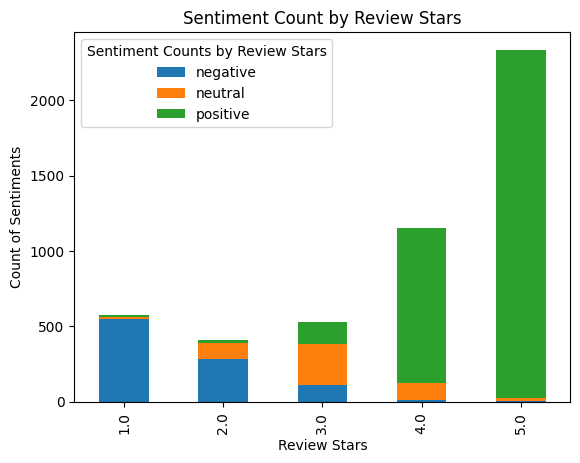

In [46]:
# Aggregate sentiments by review stars
sentiment_counts = test4.groupby(['review_stars', 'hf_sent_label']).size().reset_index(name='total_sentiment')

# Pivot the DataFrame for easier plotting
pivot_df = sentiment_counts.pivot(index='review_stars', columns='hf_sent_label', values='total_sentiment').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True)
plt.title('Sentiment Count by Review Stars')
plt.xlabel('Review Stars')
plt.ylabel('Count of Sentiments')
plt.legend(title='Sentiment Counts by Review Stars')
plt.show()

This makes a lot of sense since most of the negative sentiment/blue color are in lower ratings and most of the positive sentiment/positive color are in higher ratings with neutral/orange concentrated in center of visualization: rating 3.

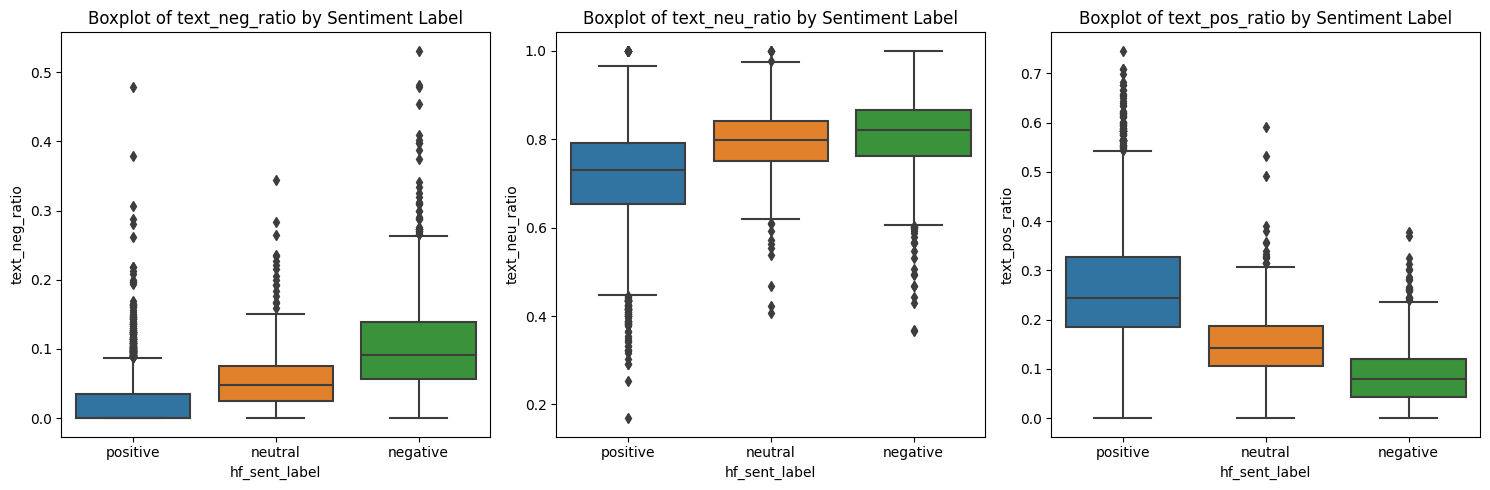

In [47]:
# Look at the box plot of sentiment ratios broken down by overall sentiment
# Plot boxplots for text_neg_ratio, text_neu_ratio, and text_pos_ratio broken down by hf_sent_label
plt.figure(figsize=(15, 5))

# Plot for text_neg_ratio
plt.subplot(1, 3, 1)
sns.boxplot(x='hf_sent_label', y='text_neg_ratio', data=test4)
plt.title('Boxplot of text_neg_ratio by Sentiment Label')

# Plot for text_neu_ratio
plt.subplot(1, 3, 2)
sns.boxplot(x='hf_sent_label', y='text_neu_ratio', data=test4)
plt.title('Boxplot of text_neu_ratio by Sentiment Label')

# Plot for text_pos_ratio
plt.subplot(1, 3, 3)
sns.boxplot(x='hf_sent_label', y='text_pos_ratio', data=test4)
plt.title('Boxplot of text_pos_ratio by Sentiment Label')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

High negative and high positive ratios correspond with neg/pos sentiments. Review sentiment composition gets murky with neutral sentiment since a neutral stance with a restaurant can have a bunch of negative or neutral comments. Would need to look at star rating to get a better view of what sentiment is majority in neutral classified reviews. Let's take a quick peek.

In [48]:
query = """
select review_stars
, clean_text
, hf_sent_label
, text_neu_ratio
, text_neg_ratio
, text_pos_ratio
from test4
where hf_sent_label = 'neutral'
"""

neutral = duckdb.query(query).df()
neutral.head(10)

,review_stars,clean_text,hf_sent_label,text_neu_ratio,text_neg_ratio,text_pos_ratio
0,2.0,we had been looking forward to visiting and staying at the gaylord opryland for months. the cascades restaurant looks wonderful with gardens and flowing water every where.$ prices: highfood quality: 3/5ambiance: 5/5server: 4/5the reason for the low score is the cascade manager inhospitable accommodation toward my family. with a virtually empty restaurant we were seated at a table for five with the sun shining in our faces. when we asked the waiter for a new table he informed us after talking with the manager the other tables were reserved and we had to stay in sunny area. we relented because the waiter was very nice and apologetic. when we finished dinner and talked for a while an hour and half had passed since our arrival i noticed the restaurant attendance level had changed very little and tables we had asked to be moved to remained empty. if you have a bigger family or have more than four in your group go somewhere else. four or less expect okay food at high prices with wonderful service and amazing ambiance.,neutral,0.870,0.030,0.100
1,3.0,"ok, the broth was homemade and meaty, the noodles homemade (as opposed to most fof the noodle places in town). but 9$ for a small bowl of ramen from a food truck you have to eat standing up? what is about food trucks in this town: they're supposed to be cheaper than sit-down restaurants. i hate to criticize what is a pretty good ramen in a town without, but i can't get over the price. and the ""ramen burger"" is a cheap gimmick copying nyc and la. wish they had a veggie option too (miso and mushroom broth with tofu).",neutral,0.798,0.078,0.123
2,4.0,"my boyfriend and i had our first meet-and-greet here (because we met on the internet, and i am clearly not too proud to publically admit it), so i am biased in favor of ""the vous."" that is, until he cold-heartedly leaves me for a younger, prettier girl, in which case i will then cry and kick sidewalk dust towards the front door in disgust and despair. but let's not be cynical. the rendevous has awesome drink specials, a dive-y neighborhood-y feel, and decent food. service is just fine. what's not to like?",neutral,0.708,0.119,0.172
3,4.0,"i've been here on the first floor a few times before predators games for a quick bite to eat. the food is pretty good but i wouldn't quite say it's the best for the price. understandably, it is located on broadway. it is also quite difficult to get a seat here if there's anything going on downtown or at bridgestone.",neutral,0.793,0.056,0.150
4,5.0,"where have you been all my life you filthy little shop?! oh right, way the hell out in south county. but i'd walk 500 miles for the goodness here. it was insane at 10am on a saturday, but the ladies there handled the crowd with ease (though they could use a better queuing process). i expected ""classic"" donuts only, but there were amazing ""specialty"" donuts here that i would've paid $3 for like at the hipster places, but were still just $0.85. the cheesecake and red velvet were just out of this world. the only one we didn't really like was the cream filled, the pastry cream was bland. everything else...amaze-balls. ps. donut drive in is still the winner for ""classic"" donuts though, and easier to get to for me.",neutral,0.752,0.041,0.207
5,3.0,"it's pricey for what you get... the first time i came here it was really good. had a nice sampling of the tacos, and mezcal drinks. the mezcal drinks were probably better than the tacos. the second visit i had one drink only (was driving) and another nice sampling of tacos. i had the crispy beef belly and the moment i bit in to it it tasted funky.... later that night (about 3-am) i was hurling on the angry chair. not from the booze. definitely from the food. i know a booze hurl believe me. so that said, it wasn't an ideal experience.",neutral,0.807,0.056,0.137
6,2.0,"heard many things about it and finally able to give it a try

Text mostly is comprised of what:

0. neutral then little neg; neutral ratio correct
1. neg; wrong neg ratio
2. pos and neg (60%); wrong ratio for pos
3. pos, neutral, neg; wrong ratio for pos
4. pos, neg; pos was second
5. neg, pos; neg was low percent
6. neg, pos; neg is lowest ratio
7. pos and neg; pos is higher than neg but neu highest
8. neg, pos; pos has higher ratio than neg but neu highest
9. pos, neg; pos then neg but neu ratio is highest

Mapping review stars to sentiment is difficult because people have varying subjectve definitions for what deserves a 1 versus 5.

In [49]:
dfr.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,review_id,user_id,review_stars,text,date
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area.",2014-05-26 01:09:53
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town.",2013-10-05 15:19:06
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite.",2013-10-25 01:34:57
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,I ordered a graduation cake for my niece and it came out absolut

In [50]:
# Join sample table to dfr to get category and date for review

query = """
select *
from test4
inner join (select review_id as review_id, categories, date from dfr) as dfr
on test4.review_id = dfr.review_id
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date
0,CB0U8V_3-Lqo9qeeCEpBgQ,2.0,"came in here yesterday for lunch/ dinner everyone was super friendly and food and drinks came out a timely fashion although the place was not busy at all so maybe that's why. my boyfriend ordered fried gater and raw oysters, i had rice and beans with sausage it all tasted fine as we sat there and ate it , with that being said my boyfriend ended up throwing up constantly and with stomach issues all night and the next day he just layed in bed all day we were not drinking so it wasn't hung over or anything and my stomach had problems as well i'm pretty sure it's food poising so just a heads up for the next person who eats here",neutral,0.829009,0.021,0.854,0.126,CB0U8V_3-Lqo9qeeCEpBgQ,"Southern, Event Planning & Services, Restaurants, Cajun/Creole, Seafood, Live/Raw Food, Hotels & Travel, Hotels",2019-02-22 22:51:20
1,P3uKW6_unvmUC4pd0sAKpQ,3.0,"we liked it so much the first time that we came back. we had lunch there the first time we ate there. i had the gumbo, charbroiled oysters, and the chicken and waffles. i should have just ordered the bowl of gumbo instead of the chicken and waffles. as for the charbroiled oysters, they were good but not cleaned as well as some of the other places. i can't stand eating into shell. but the flavor was good. they buy a cajun sauce in the shell so it adds a twist to them. the gumbo was very good. i would above back for that. i thought the chicken and waffles was gross but that my be my personal taste. i wanted to try it because it's so popular but i now know i do t like chicken and waffles. the next day we wanted to try the breakfast. i can say i order the cajun benedict it would have been excellent if the crawfish sauce was warm. they put a pouched egg over fried green tomatoes. talk about good! but had the sauce been warm it would have taken it to the next level.",neutral,0.668622,0.031,0.811,0.158,P3uKW6_unvmUC4pd0sAKpQ,"Southern, Event Planning & Services, Restaurants, Cajun/Creole, Seafood, Live/Raw Food, Hotels & Travel, Hotels",2018-12-04 07:06:53
2,YYMNuWpsSXmzVmlD3IdDBw,5.0,"what's a pupusa? sounds nasty, right? call it what you want, but it's a stuffed arepa. in mexico they have the huarache. in colombia and venezuela, they have arepas. in central america, they have pupusas. if you haven't had one, go today. don't be fooled by the pupusa loca though. stick to the smaller ones on the first menu page. go with two ingredients for each. chicken and cheese and chicarrón and cheese. top those bad boys off with their central american kraut and thin tomato sauce. then, add one drop of the yucatan xxxtra hit sauce. mix ut up on top of the pupusa and boom! you won't be sad at all. i've been twice in the last week. nuff said.",positive,0.956621,0.072,0.836,0.092,YYMNuWpsSXmzVmlD3IdDBw,"Latin American, Restaurants, Salvadoran",2018-08-04 14:38:45
3,iTi10RgKtSDY8XeggUEgJw,3.0,really good chicken wings!! service always very friendly! not really a fan of the pizza but they must be doing something right( i think the cornmeal throws me off),positive,0.990129,0.052,0.779,0.169,iTi10RgKtSDY8XeggUEgJw,"Nightlife, Pizza, Bars, Restaurants",2011-01-04 20:11:14
4,bsjrykwC0aS23mz4IQazbw,5.0,"breakfast at first watch yesterday was fabulous! we went during a peak time, but there was no wait. our server was amazing! she checked on us right away and told a bit about some of the items on the menu. she was friendly and helpful and made sure everything was going well throughout our visit. i ordered the blueberry pancake - this is my regular for breakfast a lot. it was huge and tasty! i also had to try the special million dollar bacon - soooooo worth it! it is sweet but spicy; that kick gets ya at the end! hubby ordered the worx omelette and said it was very good. i tried his potatoes and really liked them - they had a nice onion flavor and were perfec

In [51]:
# top categories mentioned in reviews
test5['categories'].value_counts()

categories
Restaurants, Mexican                                                                                                                                    113
Restaurants, Pizza                                                                                                                                       67
Restaurants, Chinese                                                                                                                                     59
Restaurants, Italian                                                                                                                                     52
Restaurants, American (New)                                                                                                                              33
                                                                                                                                                       ... 
Nightlife, Mexican, Bars, Restaurants, Food Trucks, V

In [52]:
# Sentiment breakdown for category; only work with top 5
query = """
select *
from test5
where categories in ('Restaurants, Mexican', 'Restaurants, Pizza', 'Restaurants, Chinese', 'Restaurants, Italian', 'Restaurants, Seafood')
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date
0,NpzJa5M5BjlmOVwlzOP14g,5.0,"love this place!!! with a name like hong kong express you wouldn't think they have the best wings in area. amazing!!! also try the pot stickers, top notch every time.",positive,0.998395,0.000,0.576,0.424,NpzJa5M5BjlmOVwlzOP14g,"Restaurants, Chinese",2016-06-25 02:11:56
1,vcDJ4gE4kllkvbeRWrGfwQ,4.0,nice family bar and restaurant. the blt is the best i have ever had! my mom had the cheeseburger wrap and also enjoyed it. my only suggestion is that the french fries were coated and fried. could use improvement.,positive,0.997324,0.000,0.714,0.286,vcDJ4gE4kllkvbeRWrGfwQ,"Restaurants, Seafood",2016-03-14 22:38:38
2,93MoJ1xWiBJpSTpP6VT5zA,5.0,"this is my second visit. was mostly happy with my first visit in march. had just had surgery so not up to par. (me)today, being takeout only due to covid-19, i was so pleasantly surprised to find wonderful service and great food when i got home!i ordered pescadaro frita, a whole fish deep fried with seasoned salt. it came with salad, fries, rice, halved limes, and tortillas. everything was wrapped up right and with thought and detail. very much appreciated. an incredible deal at under $20 and very delicious!",positive,0.997384,0.000,0.754,0.246,93MoJ1xWiBJpSTpP6VT5zA,"Restaurants, Seafood",2020-05-03 05:39:31
3,T4u5wGQNulGTSvNF6uxmFQ,5.0,"terrific food, great ambiance, and the staff is wonderful. old school vibe with a touch of nouveau. well worth the trip.",positive,0.997636,0.000,0.502,0.498,T4u5wGQNulGTSvNF6uxmFQ,"Restaurants, Italian",2021-12-24 23:06:52
4,g2IQyozpE1l8Fdbu9AEF8Q,5.0,delicious! good portion sizes for prices.the drive thru wasn't very slow either. cashier spoke very clearly and ensured my order was correct.,positive,0.986636,0.000,0.658,0.342,g2IQyozpE1l8Fdbu9AEF8Q,"Restaurants, Mexican",2014-10-08 20:28:25
5,dkr-K8HI8MRGLIxLB7QHiw,4.0,"can't believe i've never reviewed joey b's. i was there for dinner on a thursday night with a group of 5. we shared the avocado eggrolls and the onion rings for appetizers. i had one of each and i loved them both! the onion rings are enormous! really crispy and good and love the horseradish dipping sauce they come with. i love avocado with anything so the eggrolls are a no brainer. for dinner i ordered pepperoni pizza. my first pizza in almost two months and it did not disappoint. thin, crispy crust and gooey provel cheese just like i like. other orders at the table were the roast beef sandwich, the cod sandwich, and another sandwich i do not remember. everyone was happy, service was friendly, and we left with lots of to go boxes. of course we'll all be back!",positive,0.997003,0.014,0.775,0.211,dkr-K8HI8MRGLIxLB7QHiw,"Restaurants, Italian",2018-06-02 15:18:30
6,gWuKq6xDioD9J50-vPNNEQ,4.0,"el merendero got it's start as an a&w restaurant in 1965, but today, it's one of the best mexican restaurants on south 12th avenue. i had dinner here with the family and two of my son's friends tonight. if you happen to be in the area, el merendero is definitely worth a visit. i had the chile rellenos, and they were some of the best i've ever had! very spicy & delicious, and for $7.99- hard to beat. they come with rice and beans, and a small side of chopped lettuce. as an appetizer, we shared an order of guacamole for the table. it came with chips and a small side of pico de gallo for $4.99. sort of pricey for a small side of guacamole, but none of us were disappointed, as the chips and salsa were free. the other members of our party either had rolled tacos, hard shell tacos, or soft shell tacos. you can't go wrong with any of these choices. this place is clean, casual, friendly, and overall reasonably priced. they also have numerous seafood options on the menu, including mexican fish and shrimp cocktails, even oysters- though none of us was feeling quite so adventurous as to try one of the seafo

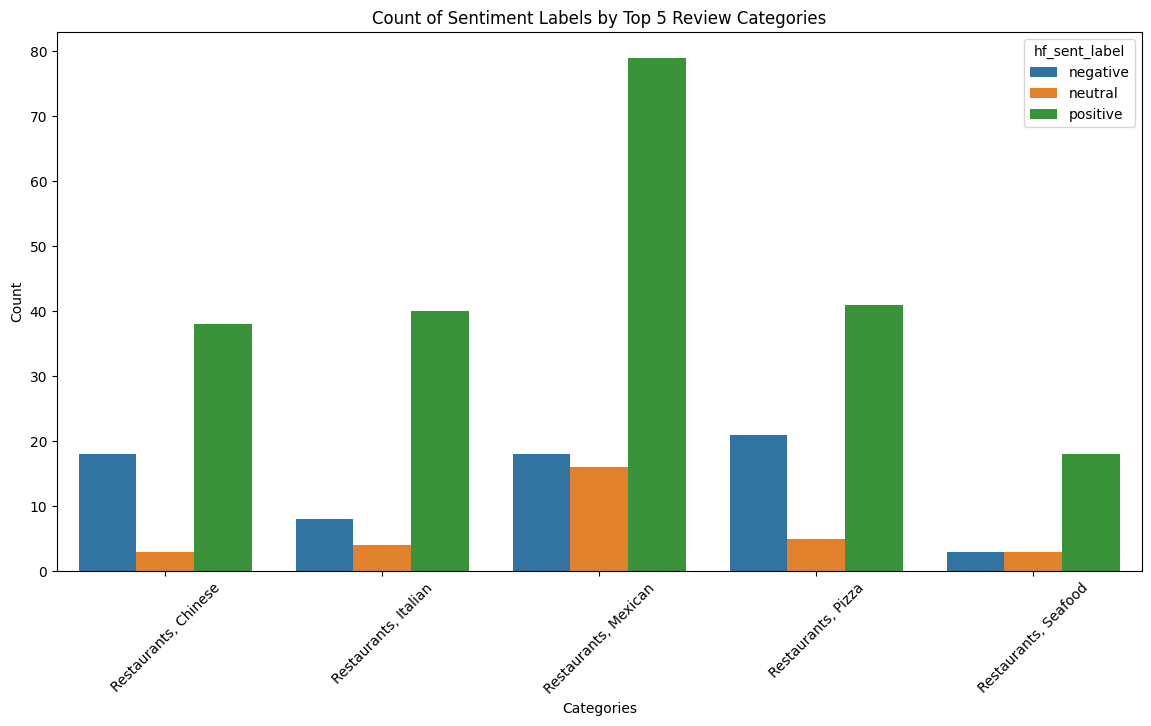

In [53]:
# Group by hf_sent_label and categories and count occurrences
df_grouped = test5.groupby(['hf_sent_label', 'categories']).size().reset_index(name='count')

# Plot the results
plt.figure(figsize=(14, 7))
sns.barplot(x='categories', y='count', hue='hf_sent_label', data=df_grouped)
plt.xticks(rotation=45)
plt.title('Count of Sentiment Labels by Top 5 Review Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

For Mexican Restaurants, positive reviews far outweigh any other cateory.

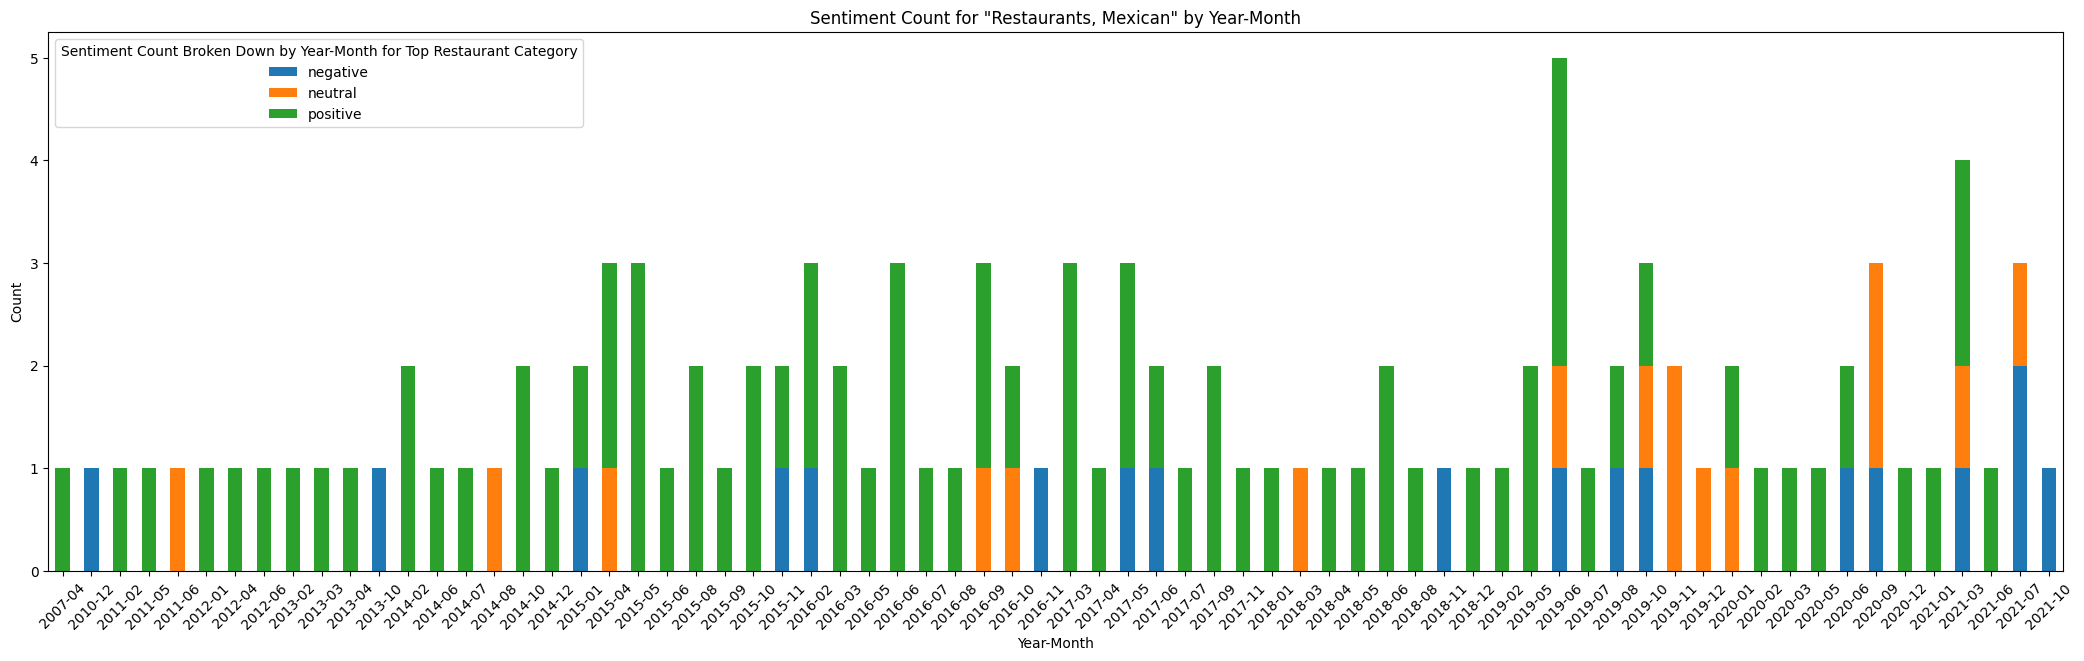

In [54]:
# Sentiment over time for top category: Restaurants, Mexican
# Filter the DataFrame to include only rows where categories is 'Restaurants, Mexican'
df_filtered = test5[test5['categories'] == 'Restaurants, Mexican']

# Convert the date column to datetime
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Extract year and month from the date column
df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

# Group by hf_sent_label and year_month and count occurrences
df_grouped = df_filtered.groupby(['hf_sent_label', 'year_month']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='year_month', columns='hf_sent_label', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Sentiment Count for "Restaurants, Mexican" by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Count Broken Down by Year-Month for Top Restaurant Category')
plt.show()

Mexican Restaurant category did best in 2018 spring. Would be interesting to focus in on one particular business and see sentiment trend over time.

And of course we want to know what are the reasons for certain sentiments. 
First, let's look at the most talked about topics in these restaurnt reviews.

# Topic Modeling


Extensive pre-processing need to be done because topic modeling cannot interpret all the text noise as well as Hugging Face LLM's can.

In [55]:
test6 = df_filtered.copy()

In [56]:
# Expand contractions and translate common social acronyms

# Dictionary for contractions
contractions_dict = {
    "i've": "I have",
    "can't": "cannot",
    "won't": "will not",
    "i'm": "I am",
    "you're": "you are",
    "they're": "they are",
    "we're": "we are",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "doesn't": "does not",
    "don't": "do not",
    "didn't": "did not",
    "mustn't": "must not",
    "mightn't": "might not",
    "needn't": "need not",
    "you'd": "you would",
    "they'd": "they would",
    "we'd": "we would",
    "she'd": "she would",
    "he'd": "he would",
    "i'd": "I would",
    "it'd": "it would",
    "who'd": "who would",
    "what's": "what is",
    "how's": "how is",
    "let's": "let us",
    "here's": "here is"
}

# Dictionary for social acronyms
acronyms_dict = {
    "lol": "laugh out loud",
    "brb": "be right back",
    "gtg": "got to go",
    "idk": "I do not know",
    "imho": "in my humble opinion",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "afaik": "as far as I know",
    "asap": "as soon as possible",
    "bff": "best friends forever",
    "fyi": "for your information",
    "lmk": "let me know",
    "nvm": "never mind",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wtf": "what the heck",
    "wth": "what the heck",
    "xoxo": "hugs and kisses"
}

# Combine both dictionaries
combined_dict = {**contractions_dict, **acronyms_dict}

# Function to expand contractions and acronyms
def expand_text(text):
    def replace(match):
        return combined_dict[match.group(0).lower()]

    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in combined_dict.keys()) + r')\b', re.IGNORECASE)
    expanded_text = pattern.sub(replace, text)
    return expanded_text

# Example usage
# text = "I've been busy lol. IDK what's happening, but can't wait to see you!"
# expanded_text = expand_text(text)
# print(expanded_text)

In [57]:
# given context of reviews, need to translate $ and % amounts into english

# def translate_amounts(text):
#     # Define regex patterns for dollar amounts and percentages
#     dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
#     percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

#     # Replace dollar amounts with "X dollars"
#     text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
#     # Replace percentages with "X percent"
#     text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
#     return text

# Example usage
# text = "The price is $4.00 and the discount is 4%."
# translated_text = translate_amounts(text)
# print(translated_text)  # Output: The price is 4.0 dollars and the discount is 4.0 percent.

In [58]:
# def replace_ampersand(text):
#     return text.replace('&', 'and')

# sentence = 'This is a test for &'
# print(replace_ampersand(sentence))

In [59]:
# def remove_punctuation(text):
#     return re.sub(r'[^\w\s]', '', text)

In [60]:
def more_txt_prep(text):
    # Define regex patterns for dollar amounts and percentages
    dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
    percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

    # Replace dollar amounts with "X dollars"
    text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
    # Replace percentages with "X percent"
    text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
    #replace ampersand
    text = text.replace('&', 'and')
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [61]:
# Some More Text Pre-Processing: tokenize, lemmatize, remove stop words

test6['clean_text2'] = test6.apply(lambda row: expand_text(row.clean_text), axis = 1)
test6['clean_text2'] = test6.apply(lambda row: more_txt_prep(row.clean_text2), axis = 1)
test6['tokenized'] = test6.apply(lambda row: tokenizer.tokenize(row.clean_text2), axis = 1)
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date,year_month,clean_text2,tokenized
4,g2IQyozpE1l8Fdbu9AEF8Q,5.0,delicious! good portion sizes for prices.the drive thru wasn't very slow either. cashier spoke very clearly and ensured my order was correct.,positive,0.986636,0.000,0.658,0.342,g2IQyozpE1l8Fdbu9AEF8Q,"Restaurants, Mexican",2014-10-08 20:28:25,2014-10,delicious good portion sizes for pricesthe drive thru was not very slow either cashier spoke very clearly and ensured my order was correct,"[delicious, good, portion, sizes, for, prices, ##the, drive, thru, was, not, very, slow, either, cash, ##ier, spoke, very, clearly, and, ensured, my, order, was, correct]"
6,gWuKq6xDioD9J50-vPNNEQ,4.0,"el merendero got it's start as an a&w restaurant in 1965, but today, it's one of the best mexican restaurants on south 12th avenue. i had dinner here with the family and two of my son's friends tonight. if you happen to be in the area, el merendero is definitely worth a visit. i had the chile rellenos, and they were some of the best i've ever had! very spicy & delicious, and for $7.99- hard to beat. they come with rice and beans, and a small side of chopped lettuce. as an appetizer, we shared an order of guacamole for the table. it came with chips and a small side of pico de gallo for $4.99. sort of pricey for a small side of guacamole, but none of us were disappointed, as the chips and salsa were free. the other members of our party either had rolled tacos, hard shell tacos, or soft shell tacos. you can't go wrong with any of these choices. this place is clean, casual, friendly, and overall reasonably priced. they also have numerous seafood options on the menu, including mexican fish and shrimp cocktails, even oysters- though none of us was feeling quite so adventurous as to try one of the seafood cocktails or dishes. as i said, if you're in the area- this place is definitely worth trying... be aware that for parties of 6 or more, they do add on the tip. our check, with tax and (added on) gratuity came to $85 for a party of 6. we each had a beverage ($2.25 for horchata and $1.99 for soft drinks), and no one had dessert. overall, the food is very good, but in my opinion- prices are a tad high for the location. this was a totally enjoyable casual dining experience- one worth putting on your tucson mexican food to try list.",positive,0.991952,0.028,0.743,0.229,gWuKq6xDioD9J50-vPNNEQ,"Restaurants, Mexican",2012-01-07 06:57:00,2012-01,el merendero got it is start as an aandw restaurant in 1965 but today it is one of the best mexican restaurants on south 12th avenue i had dinner here with the family and two of my sons friends tonight if you happen to be in the area el merendero is definitely worth a visit i had the chile rellenos and they were some of the best I have ever had very spicy and delicious and for 799 dollars hard to beat they come with rice and beans and a small side of chopped lettuce as an appetizer we shared an order of guacamole for the table it came with chips and a small side of pico de gallo for 499 dollars sort of pricey for a small side of guacamole but none of us were disappointed as the chips and salsa were free the other members of our party either had rolled tacos hard shell tacos or soft shell tacos you cannot go wrong with any of these choices this place is clean casual friendly and overall reasonably priced they also have numerous seafood options on the menu including mexican fish and shrimp cocktails even oysters though none of us was feeling quite so adventurous as to try one of the seafood cocktails or dishes as i said if you are in the area this place is definitely worth trying be aware that for parties of 6 or more they do add on the tip our check with tax and added on gratuity came to 850 dollars for a party of 6 we each had a beverage 225 dollars for horchata and 199 dollars for soft drinks and no one had dessert overall

In [62]:
# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

# Remove stop words from the 'tokens' column
test6['tokens_no_stopwords'] = test6['tokenized'].apply(remove_stopwords)

test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords
4,g2IQyozpE1l8Fdbu9AEF8Q,5.0,delicious! good portion sizes for prices.the drive thru wasn't very slow either. cashier spoke very clearly and ensured my order was correct.,positive,0.986636,0.000,0.658,0.342,g2IQyozpE1l8Fdbu9AEF8Q,"Restaurants, Mexican",2014-10-08 20:28:25,2014-10,delicious good portion sizes for pricesthe drive thru was not very slow either cashier spoke very clearly and ensured my order was correct,"[delicious, good, portion, sizes, for, prices, ##the, drive, thru, was, not, very, slow, either, cash, ##ier, spoke, very, clearly, and, ensured, my, order, was, correct]","[delicious, good, portion, sizes, prices, ##the, drive, thru, slow, either, cash, ##ier, spoke, clearly, ensured, order, correct]"
6,gWuKq6xDioD9J50-vPNNEQ,4.0,"el merendero got it's start as an a&w restaurant in 1965, but today, it's one of the best mexican restaurants on south 12th avenue. i had dinner here with the family and two of my son's friends tonight. if you happen to be in the area, el merendero is definitely worth a visit. i had the chile rellenos, and they were some of the best i've ever had! very spicy & delicious, and for $7.99- hard to beat. they come with rice and beans, and a small side of chopped lettuce. as an appetizer, we shared an order of guacamole for the table. it came with chips and a small side of pico de gallo for $4.99. sort of pricey for a small side of guacamole, but none of us were disappointed, as the chips and salsa were free. the other members of our party either had rolled tacos, hard shell tacos, or soft shell tacos. you can't go wrong with any of these choices. this place is clean, casual, friendly, and overall reasonably priced. they also have numerous seafood options on the menu, including mexican fish and shrimp cocktails, even oysters- though none of us was feeling quite so adventurous as to try one of the seafood cocktails or dishes. as i said, if you're in the area- this place is definitely worth trying... be aware that for parties of 6 or more, they do add on the tip. our check, with tax and (added on) gratuity came to $85 for a party of 6. we each had a beverage ($2.25 for horchata and $1.99 for soft drinks), and no one had dessert. overall, the food is very good, but in my opinion- prices are a tad high for the location. this was a totally enjoyable casual dining experience- one worth putting on your tucson mexican food to try list.",positive,0.991952,0.028,0.743,0.229,gWuKq6xDioD9J50-vPNNEQ,"Restaurants, Mexican",2012-01-07 06:57:00,2012-01,el merendero got it is start as an aandw restaurant in 1965 but today it is one of the best mexican restaurants on south 12th avenue i had dinner here with the family and two of my sons friends tonight if you happen to be in the area el merendero is definitely worth a visit i had the chile rellenos and they were some of the best I have ever had very spicy and delicious and for 799 dollars hard to beat they come with rice and beans and a small side of chopped lettuce as an appetizer we shared an order of guacamole for the table it came with chips and a small side of pico de gallo for 499 dollars sort of pricey for a small side of guacamole but none of us were disappointed as the chips and salsa were free the other members of our party either had rolled tacos hard shell tacos or soft shell tacos you cannot go wrong with any of these choices this place is clean casual friendly and overall reasonably priced they also have numerous seafood options on the menu including mexican fish and shrimp cocktails even oysters though none of us was feeling quite so adventurous as to try one of the seafood cocktails or dishes as i said if you are in the area this place is definitely worth trying be aware that for parties of 6 or more they do add on the tip our check with tax and added on grat

In [63]:
# Function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

# Example DataFrame
# data = {
#     'text': ["I love eating tacos.", "The taco was delicious!"],
#     'tokens': [["I", "love", "eating", "tacos"], ["The", "taco", "was", "delicious"]]
# }
# df = pd.DataFrame(data)

# Apply the lemmatization function to the 'tokens' column
test6['lemmatized_tokens'] = test6['tokens_no_stopwords'].apply(lemmatize_tokens)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens
4,g2IQyozpE1l8Fdbu9AEF8Q,5.0,delicious! good portion sizes for prices.the drive thru wasn't very slow either. cashier spoke very clearly and ensured my order was correct.,positive,0.986636,0.000,0.658,0.342,g2IQyozpE1l8Fdbu9AEF8Q,"Restaurants, Mexican",2014-10-08 20:28:25,2014-10,delicious good portion sizes for pricesthe drive thru was not very slow either cashier spoke very clearly and ensured my order was correct,"[delicious, good, portion, sizes, for, prices, ##the, drive, thru, was, not, very, slow, either, cash, ##ier, spoke, very, clearly, and, ensured, my, order, was, correct]","[delicious, good, portion, sizes, prices, ##the, drive, thru, slow, either, cash, ##ier, spoke, clearly, ensured, order, correct]","[delicious, good, portion, size, price, #, #, the, drive, thru, slow, either, cash, #, #, ier, spoke, clearly, ensure, order, correct]"
6,gWuKq6xDioD9J50-vPNNEQ,4.0,"el merendero got it's start as an a&w restaurant in 1965, but today, it's one of the best mexican restaurants on south 12th avenue. i had dinner here with the family and two of my son's friends tonight. if you happen to be in the area, el merendero is definitely worth a visit. i had the chile rellenos, and they were some of the best i've ever had! very spicy & delicious, and for $7.99- hard to beat. they come with rice and beans, and a small side of chopped lettuce. as an appetizer, we shared an order of guacamole for the table. it came with chips and a small side of pico de gallo for $4.99. sort of pricey for a small side of guacamole, but none of us were disappointed, as the chips and salsa were free. the other members of our party either had rolled tacos, hard shell tacos, or soft shell tacos. you can't go wrong with any of these choices. this place is clean, casual, friendly, and overall reasonably priced. they also have numerous seafood options on the menu, including mexican fish and shrimp cocktails, even oysters- though none of us was feeling quite so adventurous as to try one of the seafood cocktails or dishes. as i said, if you're in the area- this place is definitely worth trying... be aware that for parties of 6 or more, they do add on the tip. our check, with tax and (added on) gratuity came to $85 for a party of 6. we each had a beverage ($2.25 for horchata and $1.99 for soft drinks), and no one had dessert. overall, the food is very good, but in my opinion- prices are a tad high for the location. this was a totally enjoyable casual dining experience- one worth putting on your tucson mexican food to try list.",positive,0.991952,0.028,0.743,0.229,gWuKq6xDioD9J50-vPNNEQ,"Restaurants, Mexican",2012-01-07 06:57:00,2012-01,el merendero got it is start as an aandw restaurant in 1965 but today it is one of the best mexican restaurants on south 12th avenue i had dinner here with the family and two of my sons friends tonight if you happen to be in the area el merendero is definitely worth a visit i had the chile rellenos and they were some of the best I have ever had very spicy and delicious and for 799 dollars hard to beat they come with rice and beans and a small side of chopped lettuce as an appetizer we shared an order of guacamole for the table it came with chips and a small side of pico de gallo for 499 dollars sort of pricey for a small side of guacamole but none of us were disappointed as the chips and salsa were free the other members of our party either had rolled tacos hard shell tacos or soft shell tacos you cannot go wrong with any of these choices this place is clean casual friendly and overall reasonably priced they also have numerous seafood options on the menu including mexican fish and shrimp cocktails even oysters though none of us was feeling quite so adventurous as to try one of the seafood cocktails or dishes as i said if y

In [64]:
# turn cleaned up text column back to strings only

# Function to join list of strings into a single string
def list_to_string(list_of_strings):
    text = ' '.join(list_of_strings)
    return re.sub(r'[^\w\s]', '', text)  # remove punctuation again...

    
test6['clean_text3'] = test6['lemmatized_tokens'].apply(list_to_string)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens,clean_text3
4,g2IQyozpE1l8Fdbu9AEF8Q,5.0,delicious! good portion sizes for prices.the drive thru wasn't very slow either. cashier spoke very clearly and ensured my order was correct.,positive,0.986636,0.000,0.658,0.342,g2IQyozpE1l8Fdbu9AEF8Q,"Restaurants, Mexican",2014-10-08 20:28:25,2014-10,delicious good portion sizes for pricesthe drive thru was not very slow either cashier spoke very clearly and ensured my order was correct,"[delicious, good, portion, sizes, for, prices, ##the, drive, thru, was, not, very, slow, either, cash, ##ier, spoke, very, clearly, and, ensured, my, order, was, correct]","[delicious, good, portion, sizes, prices, ##the, drive, thru, slow, either, cash, ##ier, spoke, clearly, ensured, order, correct]","[delicious, good, portion, size, price, #, #, the, drive, thru, slow, either, cash, #, #, ier, spoke, clearly, ensure, order, correct]",delicious good portion size price the drive thru slow either cash ier spoke clearly ensure order correct
6,gWuKq6xDioD9J50-vPNNEQ,4.0,"el merendero got it's start as an a&w restaurant in 1965, but today, it's one of the best mexican restaurants on south 12th avenue. i had dinner here with the family and two of my son's friends tonight. if you happen to be in the area, el merendero is definitely worth a visit. i had the chile rellenos, and they were some of the best i've ever had! very spicy & delicious, and for $7.99- hard to beat. they come with rice and beans, and a small side of chopped lettuce. as an appetizer, we shared an order of guacamole for the table. it came with chips and a small side of pico de gallo for $4.99. sort of pricey for a small side of guacamole, but none of us were disappointed, as the chips and salsa were free. the other members of our party either had rolled tacos, hard shell tacos, or soft shell tacos. you can't go wrong with any of these choices. this place is clean, casual, friendly, and overall reasonably priced. they also have numerous seafood options on the menu, including mexican fish and shrimp cocktails, even oysters- though none of us was feeling quite so adventurous as to try one of the seafood cocktails or dishes. as i said, if you're in the area- this place is definitely worth trying... be aware that for parties of 6 or more, they do add on the tip. our check, with tax and (added on) gratuity came to $85 for a party of 6. we each had a beverage ($2.25 for horchata and $1.99 for soft drinks), and no one had dessert. overall, the food is very good, but in my opinion- prices are a tad high for the location. this was a totally enjoyable casual dining experience- one worth putting on your tucson mexican food to try list.",positive,0.991952,0.028,0.743,0.229,gWuKq6xDioD9J50-vPNNEQ,"Restaurants, Mexican",2012-01-07 06:57:00,2012-01,el merendero got it is start as an aandw restaurant in 1965 but today it is one of the best mexican restaurants on south 12th avenue i had dinner here with the family and two of my sons friends tonight if you happen to be in the area el merendero is definitely worth a visit i had the chile rellenos and they were some of the best I have ever had very spicy and delicious and for 799 dollars hard to beat they come with rice and beans and a small side of chopped lettuce as an appetizer we shared an order of guacamole for the table it came with chips and a small side of pico de gallo for 499 dollars sort of pricey for a small side of guacamole but none of us were disappointed as the chips and salsa were free the other members of our party either had rolled tacos hard shell tacos or soft shell tacos you cannot go wrong with any of these choices this place is clean casual friendly and overall reasonably priced they also have numerous seafood options on the menu including mexican fish and shrimp cocktails even oyste

In [65]:
# Now trying topic modeling with cleaned text!
reindexed_data = test6['clean_text3']
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + ['food', 'ta', 'take'], use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [66]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [67]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [68]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [69]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

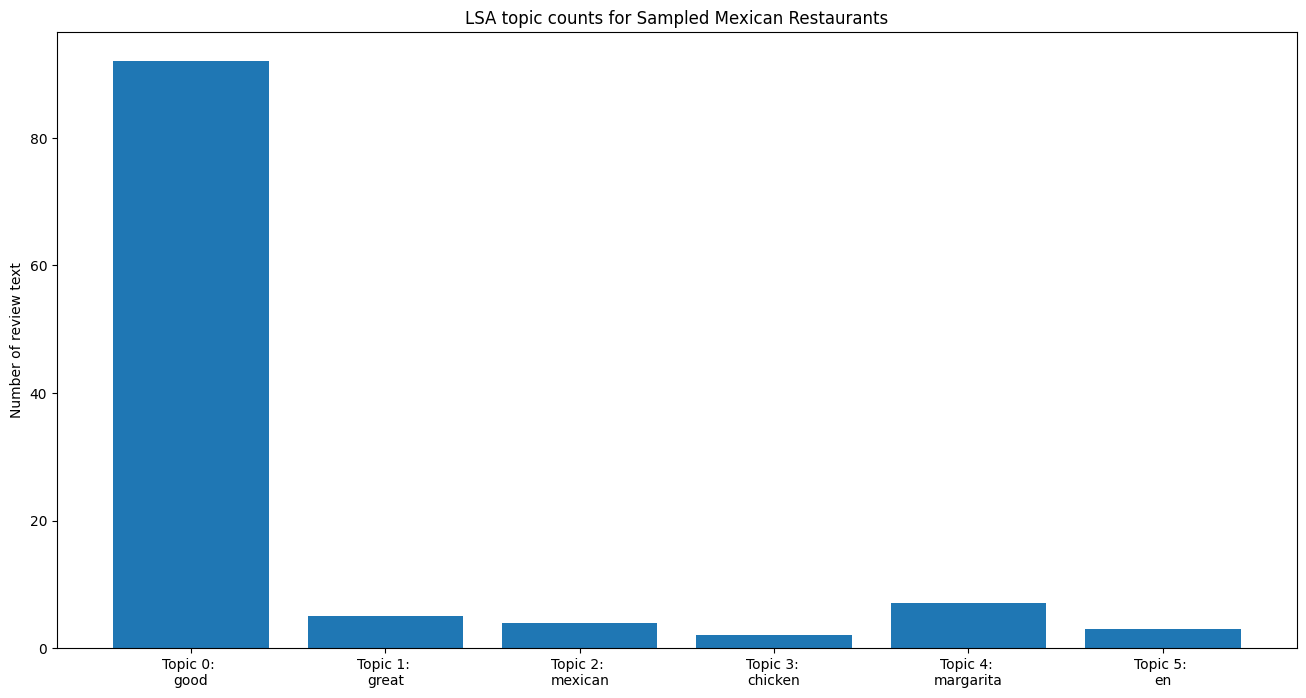

In [70]:
top_3_words = get_top_n_words(1, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts for Sampled Mexican Restaurants');
plt.show();

In [71]:
# Download NLTK stopwords
nltk.download('stopwords')

# Sample Yelp reviews DataFrame
data = {
    'review': [
        "I love the tacos at this place. They're amazing!",
        "The service was terrible, I will not come back.",
        "Great atmosphere and friendly staff.",
        "The food was cold and tasteless.",
        "I enjoyed my time here, the music was good."
    ]
}
df = pd.DataFrame(data)

# Preprocess the reviews
stop_words = set(stopwords.words('english'))
df['processed'] = df['review'].apply(lambda x: [word for word in x.lower().split() if word not in stop_words])

# Create a dictionary and corpus
dictionary = corpora.Dictionary(df['processed'])
corpus = [dictionary.doc2bow(text) for text in df['processed']]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(0, '0.083*"service" + 0.083*"back." + 0.083*"terrible," + 0.083*"come" + 0.083*"they\'re"')
(1, '0.111*"good." + 0.111*"music" + 0.111*"enjoyed" + 0.111*"here," + 0.111*"time"')
(2, '0.095*"great" + 0.095*"friendly" + 0.095*"atmosphere" + 0.095*"staff." + 0.095*"food"')


Numbers are probability that word would be chosen as topic in newly generated text.
These topics also cover adjectives. Need to do entity extraction to zoom-in on core review topics.

References:
1. https://erickleppen.medium.com/topic-modeling-for-beginners-using-bertopic-and-python-aaf1b421afeb
1. https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html

In [72]:
# Trying BERTopic

docs = test6['clean_text2']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words                     # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-06-06 01:28:52,061 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2024-06-06 01:28:57,047 - BERTopic - Embedding - Completed ✓
2024-06-06 01:28:57,048 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-06 01:29:09,341 - BERTopic - Dimensionality - Completed ✓
2024-06-06 01:29:09,342 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-06 01:29:09,379 - BERTopic - Cluster - Completed ✓
2024-06-06 01:29:09,384 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-06 01:29:09,491 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,113,-1_tacos_mexican_restaurant_burrito,"[tacos, mexican, restaurant, burrito, salsa, ordered, menu, chicken, best, chips]","[el jarocho is exactly what i need in a taco place i will never turn down free chips and salsa and it is a great way to start off for those who are more mild salsa fans the complimentary salsa does have quite a kick the service was very friendly and quick for having such an elaborate menu i was impressed with how quickly our food was delivered to our table i went for the steak tacos and was delighted the portions were generous and the tacos were hefty with three per order it was a solid meal for under 100 dollars there is a limited amount of seating so this would not be the place for groups larger than 6 especially during the dinner rush i will definitely be returning whether for dinein or takeout I am happy to know of this quality mexican food establishment, not sure if the tacos are not as good as before or if i have higher expectations for tacos now but the place is still pretty good just not great they have great atmosphere and still love their chips and guacamole, el merendero got it is start as an aandw restaurant in 1965 but today it is one of the best mexican restaurants on south 12th avenue i had dinner here with the family and two of my sons friends tonight if you happen to be in the area el merendero is definitely worth a visit i had the chile rellenos and they were some of the best I have ever had very spicy and delicious and for 799 dollars hard to beat they come with rice and beans and a small side of chopped lettuce as an appetizer we shared an order of guacamole for the table it came with chips and a small side of pico de gallo for 499 dollars sort of pricey for a small side of guacamole but none of us were disappointed as the chips and salsa were free the other members of our party either had rolled tacos hard shell tacos or soft shell tacos you cannot go wrong with any of these choices this place is clean casual friendly and overall reasonably priced they also have numerous seafood options on the menu including mexican fish and shrimp cocktails even oysters though none of us was feeling quite so adventurous as to try one of the seafood cocktails or dishes as i said if you are in the area this place is definitely worth trying be aware that for parties of 6 or more they do add on the tip our check with tax and added on gratuity came to 850 dollars for a party of 6 we each had a beverage 225 dollars for horchata and 199 dollars for soft drinks and no one had dessert overall the food is very good but in my opinion prices are a tad high for the location this was a totally enjoyable casual dining experience one worth putting on your tucson mexican food to try list]"


* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.
* Let's try another embedder.

In [73]:
#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(test6['clean_text2'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
test6['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-06-06 01:29:49,224 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-06 01:29:52,936 - BERTopic - Dimensionality - Completed ✓
2024-06-06 01:29:52,937 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-06 01:29:52,957 - BERTopic - Cluster - Completed ✓
2024-06-06 01:29:52,962 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-06 01:29:53,558 - BERTopic - Representation - Completed ✓


Topic  Count                                 Name  \
0     -1     55          -1_tacos_mexican_salsa_like   
1      0     20       0_tacos_baja_burrito_delicious   
2      1     19  1_restaurant_menu_breakfast_service   
3      2     19   2_mexican_restaurant_el_margaritas   

                                                                         Representation  \
0  [tacos, mexican, salsa, like, order, chicken, burrito, authentic, restaurant, chips]   
1     [tacos, baja, burrito, delicious, chips, salsa, corn, guacamole, shrimp, chorizo]   
2  [restaurant, menu, breakfast, service, people, items, minutes, waitress, like, busy]   
3  [mexican, restaurant, el, margaritas, area, tapatio, lolita, panchos, menu, enjoyed]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [74]:
# from sklearn.datasets import fetch_20newsgroups

# docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
# topic_model2 = BERTopic()
# topics, probs = topic_model.fit_transform(docs) 

#topic_model2.visualize_topics()

In [75]:
## debug error later
# topic_model.visualize_topics()

# Aspect Extraction: What is being talked about in the reviews? - Topics at a more granular level

# Aspect-based opinion mining

In [76]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("NUSTM/restaurant-t5-base")
# model = AutoModelForSeq2SeqLM.from_pretrained("NUSTM/restaurant-t5-base")

# input_ids = tokenizer(
#    "The pizza here is delicious!!", return_tensors="pt"
# ).input_ids  # Batch size 1
# outputs = model(input_ids=input_ids)